# **<center>Non-Attending Final Project - Luca Masserano, ID: 3017820 </center>**

## <center>**1. General Information and Code Setup**</center>

This project is split in two parts: 

- sections 2 to 10 deal with the preprocessing, annotation and analysis of song lyrics, with the final section dedicated to the construction of different models for classification;

- section 11 focuses instead on structured prediction of alphabet letters (tags) using rasterized images of handwritten characters.

Throughout the notebook, some cells containing long pieces of code or classes have been collapsed in order to increase readability. The first few sections (retrieval, cleaning, annotation) have been coded as a script due to the nature of the tasks, while for the core of the analysis I tried to build everything with classes and functions which make the code very easy to use and flexible. In this sense, some parameters are sometimes not explicitly exposed in method/function calls because they have default values, which can nonetheless be easily seen in the relevant definitions within the class.

The following cell contains all the imports for modules that are common to all sections. I will then import specific modules as I go along with the analysis.

In [1]:
import pandas as pd
import numpy as np
import logging
import sys
import os
import re
import time
import pickle
import multiprocessing
from tqdm import tqdm # useful progress bars for iterables
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
pd.set_option('display.max_columns', None) # visualize all columns in console

%run utils.ipynb # some functions used throughout the code for visualizations

## <center>**2. Research Question**</center>

Since every step in the analysis, from preprocessing to prediction, has been inspired and guided by the research question, I decided to state it before-hand.

**Being a music lover and passionate piano player, I decided to focus my analysis on song lyrics in order to try to uncover possible patterns in what different artists write and in how they use language to convey messages, taking into consideration different musical genres and time periods. To this end, I divided my research as follows:**

**1. first of all, I tried to bring out some of the inner characteristics of lyrics in terms of most used words and locutions. These were then used to guide the analysis of topics treated, with the aim of discovering if different musical genres have undergone a transformation over the years in the themes they talk about and in how they do so;**

**2. secondly, I wanted to exploit linguistic characteristics of lyrics to build a classifier able to predict the genre of a song given its text.**

## <center>**3. Dataset, Cleaning and Annotation**</center>

### **3.1 Creation of the dataset**

Looking on the internet, I found a few lyrics datasets which someone already constructed for other analysis in the past. Unfortunately, I noticed that all of them had many problems in terms of size, genre misclassification, and wrong lyrics, which would have made the analysis not just very difficult, but also inaccurate.

As a consequence I decided to create my own dataset in two steps: I first downloaded a list of artists, corresponding genres and songs from *MetroLyrics* (https://www.metrolyrics.com). This site allows free unlimited web scraping, and has also an alphabet-ordered directory of artists. For each letter, *MetroLyrics* provides a page of ~50 most popular artists across every musical genre and period, from 50 Cent, Arctic Monkeys and Shakira, to Bruce Springsteen, Billie Holiday and B.B King. Each artist has in turn a whole page of popular songs, usually from ~20 to ~80. 

Once obtained these, I used the wonderful API provided by *Genius* (https://genius.com), a huge database of song lyrics, to obtain the documents for each of the artist-song pairs mentioned above and the corresponding album and release date. 

In [ ]:
import lyricsgenius # Genius API
from textblob import TextBlob # language detector
from bs4 import BeautifulSoup
from selenium import webdriver

# setup basic logging functionality for debugging and to keep track of the retrieval progress
logging.basicConfig(filename="./log_files/lyrics_scraping.log",
                   level=logging.INFO,
                   format='%(asctime)s %(levelname)s %(message)s')

In [5]:
df_initial = pd.DataFrame({"artist":[], "song":[], "album":[], "release_date":[], "genre":[], "lyrics":[]})
df_initial.head()

,artist,song,album,release_date,genre,lyrics


#### **3.1.1 Functions for scraping artists, genres and songs**

In [3]:
def metrolyrics_retriever(output_df, 
                          driver, 
                          root_url="https://www.metrolyrics.com/top-artists.html", 
                          per_artist_limit=None, 
                          overall_limit=None):
    
    dataset = output_df
    alphabet, urls = retrieve_alphabet(root_url, driver)
    
    for letter, url in zip(alphabet, urls):
        
        artists = retrieve_artists(letter, url, driver)
        for artist, (artist_url, artist_genre) in artists.items():
            songs = retrieve_songs(artist, artist_url, driver, per_artist_limit=per_artist_limit)
            nans = [None for i in range(len(songs))]
            genre = [artist_genre for i in range(len(songs))]
            
            artist_df = pd.DataFrame({"artist":[artist for i in range(len(songs))], 
                                      "song":songs, 
                                      "album":nans, 
                                      "release_date":nans, 
                                      "genre":genre, 
                                      "lyrics":nans})
            dataset = pd.concat([dataset, artist_df])
            dataset.reset_index(drop=True, inplace=True)
            
            
            print(f"\rSongs retrieved: {dataset.shape[0]}", end='\r')
            sys.stdout.flush()
            
            if not overall_limit is None:
                if dataset.shape[0] > overall_limit:
                    return dataset.iloc[:overall_limit, :]
        
        logging.info("Writing to csv")
        dataset.to_csv("/Users/lucamasserano/Desktop/BOCCONI/nlp/final_project/lyrics_project/songs.csv", index=False)
        
    return dataset

def retrieve_alphabet(url, driver):
    
    driver.get(url)
    html = driver.page_source
    logging.info("Alphabet html source loaded")
    soup = BeautifulSoup(html, "lxml")
    
    try:
        alphabet = soup.find("p", class_="artist-letters").find_all("a")
        letters = []
        urls = []
        for idx, letter in enumerate(alphabet):
            try:
                letter_text = letter.get_text()
                letter_url = letter.get("href")
                letters.append(letter_text)
                urls.append(letter_url)
            except AttributeError:
                logging.warning(f"Unable to retrieve artists for letter number {idx}. Html structure not aligned")
    except AttributeError:
        logging.error("Unable to retrieve urls for letters. Html structure not aligned")
    
    logging.info(f"Got letters {letters}")
    
    return letters, urls
            
def retrieve_artists(letter, letter_url, driver):
    
    logging.info(f"\nRetrieving artists for letter {letter}")
    
    driver.get(letter_url)
    html = driver.page_source
    logging.info("Html source loaded")
    soup = BeautifulSoup(html, "lxml")
    
    artists = dict()
    
    # top six artists first
    logging.info("Retrieving top artists")
    try:
        top_artists = soup.find("div", class_="module top-artists clearfix")\
                            .find_all("div", class_=['artist grid_2 alpha', 'artist grid_2 ', "artist grid_2 omega"])
        for idx, artist in enumerate(top_artists):
            try:
                box = artist.find("a", class_="image")
                artist_url = box.get("href")
                artist_name = box.find("span", class_="name").get_text()
                artist_genre = ""
                substitute = re.compile("\s*(L|l)yrics.*")
                artist_name = re.sub(substitute, "", artist_name).replace("\n", "").replace("\t", "")
                artists[artist_name] = artist_url, artist_genre
                logging.info(f"Got {artist_name}")
            except AttributeError:
                logging.warning(f"Unable to retrieve top artist number {idx}. Html structure not aligned")        
    except AttributeError:
        logging.warning(f"Unable to retrieve top artists. Html structure not aligned")
    
    # other artists
    logging.info("Retrieving other artists")
    try:
        other_artists = soup.find("table", class_="songs-table").find("tbody").find_all("tr")
        for idx, artist in enumerate(other_artists):
            try:
                box = artist.find("a")
                artist_url = box.get("href")
                artist_name = box.get_text()
                artist_genre = artist.find_all("td")[1].get_text().replace("\n", "").replace("\t", "")
                if artist_genre == "":
                    artist_genre = None
                substitute = re.compile("\s*(L|l)yrics.*")
                artist_name = re.sub(substitute, "", artist_name).replace("\n", "").replace("\t", "")
                artists[artist_name] = artist_url, artist_genre
                logging.info(f"Got {artist_name}")
            except AttributeError:
                logging.warning(f"Unable to retrieve other artist number {idx}. Html structure not aligned")        
    except AttributeError:
        logging.warning(f"Unable to retrieve other artists. Html structure not aligned")
    
    logging.info(f"Retrieved {len(artists.keys())} artists for letter {letter}")
    
    return artists
        
        
def retrieve_songs(artist, artist_url, driver, per_artist_limit):

    logging.info(f"\nRetrieving songs for {artist}")
    
    driver.get(artist_url)
    html = driver.page_source
    logging.info("Html source loaded")
    soup = BeautifulSoup(html, "lxml")
    
    try:
        titles_soup = soup.find("div", id="popular").find("div", class_="content").find("tbody").find_all("tr")
    except AttributeError:
        logging.warning(f"Unable to retrieve songs for {artist}. Html structure not aligned")
    
    titles = []
    if per_artist_limit is None:
        per_artist_limit = len(titles_soup)
    for idx, song in enumerate(titles_soup[:per_artist_limit]):
        try:
            substitute = re.compile("\s*(L|l)yrics.*")
            title = song.find("a", class_=["title hasvidtable", "title "]).get_text()
            title = re.sub(substitute, "", title).replace("\n", "").replace("\t", "")
            titles.append(title)
            logging.info(f"Got {title}")
        except AttributeError:
            logging.warning(f"Unable to retrieve song number {idx}. Html structure not aligned")
    
    logging.info(f"Retrieved {len(titles)} songs for {artist}")
    
    return titles

In [ ]:
driver = driver = webdriver.Firefox(executable_path='<YOUR_GECKODRIVER_PATH>')
songs = metrolyrics_retriever(df_initial, driver)

In [3]:
songs = pd.read_csv("./data/songs.csv")
songs.shape

(62470, 6)

#### **3.1.2 Function using the Genius API to get lyrics, albums and release dates**

Some cleaning steps act already in the retrieval phase: I kept only lyrics written in English and removed all instances with either unavailable lyrics, no token or too many (>10000), practically removing some outliers. The core of data cleaning is anyway covered in the next subsection.

In [75]:
def retrieve_lyrics(df_songs, genius_api, output_filename, avoid_artists=[]):
    
    dataset = df_songs
    artists = [arts for arts in dataset.artist.unique() if arts not in avoid_artists]
    logging.info(f"Starting after {avoid_artists[-1]}")
    counter = 0
    counter_overall = 0
    
    for artist in artists:
        logging.info(f"\nRetrieving lyrics for {artist}")
        songs = dataset.loc[dataset.artist == artist, "song"].to_list()
        album = []
        lyrics = []
        release_date = []
        for idx, song_title in enumerate(songs):
            
            try:
                song = genius_api.search_song(song_title, artist=artist)
            except Exception as e:           
                try:
                    logging.warning(f"{song_title}, {artist} not found: {e.message} {e.args}")
                except AttributeError:
                    logging.warning(f"{song_title}, {artist} {song_title}, {artist} not found: {e}")
                
                dataset = dataset.drop(
                                index=dataset.loc[(dataset.artist == artist) & (dataset.song == song_title)].index
                                ).reset_index(drop=True)
                
                counter_overall += 1
                print(f"\rLyrics retrieved: {counter} Total songs: {counter_overall}", end='\r')
                sys.stdout.flush()
                continue
            
            try:
                text = song.lyrics
                substitute = re.compile("\[.+\]")
                text = re.sub(substitute, "", text).replace("\n", " ").replace("\t", " ")
                
                try:
                    language = TextBlob(text).detect_language()
                except Exception as e:
                    try:
                        logging.warning(f"Problem detecting language for {song_title}, {artist}: {e.message} {e.args}")
                    except AttributeError:
                        logging.warning(f"Problem detecting language for {song_title}, {artist}: {e}")
                    language = "en"
                if language != "en":
                    dataset = dataset.drop(
                                index=dataset.loc[(dataset.artist == artist) & (dataset.song == song_title)].index
                                ).reset_index(drop=True)
                    logging.warning(f"Excluded {song_title}, {artist}. Lyrics language: {language}")
                    counter_overall += 1
                    print(f"\rLyrics retrieved: {counter} Total songs: {counter_overall}", end='\r')
                    sys.stdout.flush()
                    continue
                else:
                    if len(text.split()) < 10000:
                        lyrics.append(text)
                    # avoid outliers --> surely not song lyrics
                    else:
                        dataset = dataset.drop(
                                index=dataset.loc[(dataset.artist == artist) & (dataset.song == song_title)].index
                                ).reset_index(drop=True)
                        logging.warning(f"Excluded {song_title}, {artist}. Lyrics longer than 10000 words")
                        counter_overall += 1
                        print(f"\rLyrics retrieved: {counter} Total songs: {counter_overall}", end='\r')
                        sys.stdout.flush()
                        continue
                        
            except AttributeError:
                logging.warning(f"No lyrics for {song_title}. Dropping")
                dataset = dataset.drop(
                                index=dataset.loc[(dataset.artist == artist) & (dataset.song == song_title)].index
                                ).reset_index(drop=True)
                counter_overall += 1
                print(f"\rLyrics retrieved: {counter} Total songs: {counter_overall}", end='\r')
                sys.stdout.flush()
                continue
            
            try:
                album.append(song.album.replace("\n", "").replace("\t", ""))
            except AttributeError:
                album.append(None)
            
            try:
                release_date.append(song.year.replace("\n", "").replace("\t", ""))
            except AttributeError:
                release_date.append(None)
            
            logging.info(f"Got data for {song_title}")
            counter += 1
            counter_overall += 1
            print(f"\rLyrics retrieved: {counter} Total songs: {counter_overall}", end='\r')
            sys.stdout.flush()
        
        logging.info(f"Retrieved lyrics for {artist}")
        logging.info(f"Artist Dataset shape: {dataset.loc[dataset.artist == artist, :].shape}, Albums: {len(album)}, Lyrics: {len(lyrics)}, Release Date: {len(release_date)}")
        
        dataset.loc[dataset.artist == artist, "album"] = album
        dataset.loc[dataset.artist == artist, "lyrics"] = lyrics
        dataset.loc[dataset.artist == artist, "release_date"] = release_date        
        
        logging.info(f"Writing {artist} to csv")
        logging.info(f"Global Dataset shape: {dataset.shape}")
        dataset.to_csv(f"/Users/lucamasserano/Desktop/BOCCONI/nlp/final_project/lyrics_project/{output_filename}.csv", index=False)
    
    return dataset

In [78]:
api = lyricsgenius.Genius('<YOUR_API_TOKEN>', sleep_time=0.01, verbose=False)

In [ ]:
lyrics = retrieve_lyrics(songs, api, avoid_artists=[])

In [14]:
lyrics_df = pd.read_csv("./data/lyrics.csv")
lyrics_df.shape

(50466, 6)

#### **3.1.3 An example**

In [15]:
lyrics_df.loc[lyrics_df.artist == "Bruce Springsteen", :].head()

,artist,song,album,release_date,genre,lyrics
5251,Bruce Springsteen,I'm On Fire,Born in the U.S.A.,1984-06-04,Rock,"Hey, little girl, is your daddy home? Did he ..."
5252,Bruce Springsteen,Thunder Road,Born to Run,1975-08-25,Rock,"The screen door slams, Mary's dress waves Like..."
5253,Bruce Springsteen,Blinded By The Light,"Greetings From Asbury Park, N.J.",1973-01-05,Rock,Madman drummers bummers and Indians in the su...
5254,Bruce Springsteen,Born To Run,Born to Run,1975-08-25,Rock,"In the day, we sweat it out on the streets Of ..."
5255,Bruce Springsteen,The River,The River,NaN,Rock,"I come from down in the valley Where, miste..."


In [18]:
# number of artists retrieved
lyrics_df.artist.unique().shape

(1039,)

### **3.2 Data cleaning**

In [6]:
from datetime import datetime

#### **3.2.1 Drop NaNs in *lyrics* column**

Although I've already tried to catch unavailable lyrics during the data retrieval process, a quick inspection of the dataset outlines the presence of a few NaNs. This is mainly due to two reasons: 
1. first, there was a very rare server connection error that occurred while scraping and this caused some lyrics to be set to NaN while the exception was handled;
2. second, *MetroLyrics* apparently duplicated some artists starting with "The" (e.g., *The Beatles* were classified both in letter B and also in letter T). This someway caused the appearance of most of the uncaught NaNs in some of the duplicated artists. 

In [13]:
lyrics_null = lyrics_df[lyrics_df.lyrics.isnull()]
lyrics_null.shape

(1554, 6)

In [5]:
# count nans for each artist that has some
artists_null = sorted(
    [(lyrics_null[lyrics_null.artist == artist].shape[0], artist) for artist in lyrics_null.artist.unique()],
    key=lambda x: x[0], reverse=True
    )
print("lyrics_NaNs", "artist")
artists_null[:20]

lyrics_NaNs artist


[(79, 'The Cure'),
 (77, 'The Animals'),
 (75, 'The Beatles'),
 (75, 'The Carpenters'),
 (75, 'The Rolling Stones'),
 (75, 'The Killers'),
 (75, 'The Cranberries'),
 (75, 'The Muppets'),
 (75, 'The Hit Crew'),
 (75, 'The Lonely Island'),
 (72, 'The Chainsmokers'),
 (56, 'The Lumineers'),
 (49, 'The High Kings'),
 (45, 'The Phantom of the Opera (Original London Cast)'),
 (45, 'The Platters'),
 (35, 'Hans Zimmer'),
 (26, 'Yanni'),
 (21, 'Steven Universe'),
 (20, 'Quincy Jones'),
 (18, 'The Irish Descendants')]

In [20]:
lyrics_df = lyrics_df.loc[lyrics_df.lyrics.notnull(), :]
lyrics_df.shape

(48912, 6)

#### **3.2.2 Drop lyrics with nonsensical length**

In order not to negatively influence the analysis of the lyrics, it's important to drop those instances with completely unrealistic lengths. A quick inspection reveals that for some reason the *Genius* API I used has a few nonsensical instances, such as lyrics long up to 150000 tokens, or as short as 10 tokens.

Assuming that an average line of a song contains 5 to 10 words, I dropped all instances with `len < 30`, i.e. approximately less than 3 to 6 lines. As for the upper bound I dropped all lyrics with more than 2000 tokens.

Since the above only aims at dropping instances which are clearly not lyrics and at homogenizing data, I decided to do it directly on the raw dataset, without a preliminary deletion of punctuation. 

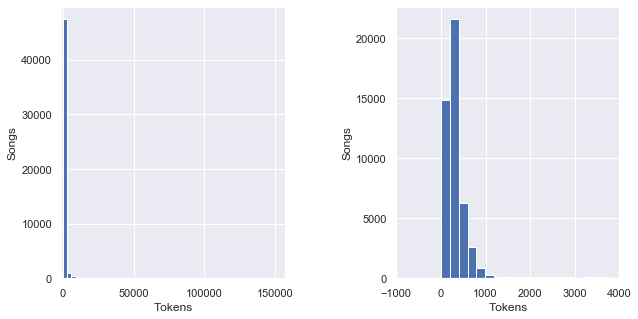

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(lyrics_df.lyrics.apply(lambda text: len(text.split())), bins=50)
ax[0].set_xlim(left=-1000)
ax[0].set_xlabel('Tokens')
ax[0].set_ylabel('Songs')

ax[1].hist(lyrics_df.lyrics.apply(lambda text: len(text.split())), bins=750)
ax[1].set_xlim(left=-1000, right=4000)
ax[1].set_xlabel('Tokens')
ax[1].set_ylabel('Songs')

plt.subplots_adjust(wspace=0.5)
plt.show()

In [22]:
lyrics_df.loc[lyrics_df.lyrics.apply(lambda text: len(text.split())) > 2000, :].shape

(2009, 6)

In [23]:
lyrics_df.loc[lyrics_df.lyrics.apply(lambda text: len(text.split())) < 30, :].shape

(533, 6)

In [24]:
lyrics_df = lyrics_df.loc[
                (lyrics_df.lyrics.apply(lambda text: len(text.split())) < 2000) &
                (lyrics_df.lyrics.apply(lambda text: len(text.split())) > 30)
                ]
lyrics_df.shape

(46357, 6)

#### **3.2.3 Drop duplicates**

Two types of duplicates need to be dropped in order to perform a coherent analysis:
1. Possible duplicates of (artist, song) couples, due to repetitions in *MetroLyrics*' database

In [11]:
lyrics_df.loc[lyrics_df.duplicated(subset=["artist", "song"], keep="first"), :].shape

(676, 6)

In [25]:
lyrics_df.drop_duplicates(subset=["artist", "song"], keep="first", inplace=True)

2. Covers of other songs

In [27]:
lyrics_df.loc[lyrics_df.duplicated(subset=["lyrics"], keep="first"), :].shape

(1836, 6)

In [28]:
lyrics_df.drop_duplicates(subset="lyrics", keep="first", inplace=True)

#### **3.2.4 Manual checks**

Quickly scrolling the dataset I noticed that there are two names for Beyoncé: Beyoncé and Beyoncé-Knowles. It makes sense to rename the latter and drop duplicates

In [15]:
lyrics_df.loc[lyrics_df.artist == "Beyonce Knowles", "artist"] = "Beyoncé"

In [16]:
lyrics_df.loc[lyrics_df.duplicated(subset=["artist", "song"], keep="first"), :].shape

(1, 6)

In [17]:
lyrics_df.drop_duplicates(subset=["artist", "song"], keep="first", inplace=True)

In [18]:
lyrics_df.shape

(43844, 6)

The dataset passed from 50466 instances to 43844 after cleaning.

### **3.3 Annotation**

#### **3.3.1 Genre**

By plotting the distribution of genres across songs it is clear that *Rock*, *Pop* and *Hip-Hop* are the most prevalent genres. Given that there are around 8000 unclassified lyrics, I would like to annotate them in order obtain the full picture and not lose any data point. 

Moreover, I inspected the artists-genre pairs and uncovered some misclassifications that I am going to correct manually.

In [19]:
# list of genres with NaNs as "None" to plot them
genres = [genre if isinstance(genre, float) is False else "None" for genre in lyrics_df.loc[:, "genre"].to_numpy()]

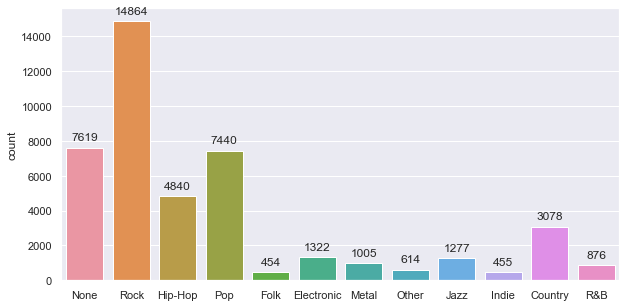

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(genres, ax=ax)
add_value_labels(ax=ax) # from utils.ipynb

#### Correction of misclassifications

In [21]:
corrected_genres = {"Metal": ["Deep Purple", "Iron Maiden", 'Metallica', 'Rammstein'],
                      "Pop": ['Alanis Morissette', 'Gwen Stefani', 'Gary Jules', 'Il Volo', 'Of Monsters And Men', 'Sugar free'], 
                      "Indie": ['Foster The People', 'Gotye', 'HOZIER'],
                      "Folk": ['Joan Baez'], 
                      "Other": ['Soundtrack'], 
                      "R&B": ['Tina Turner', 'Zucchero']
                     }

In [22]:
# update dataset with new genres annotations
for genre, artists in corrected_genres.items():
    for artist in artists:
        lyrics_df.loc[lyrics_df.artist == artist, "genre"] = [genre]*lyrics_df.loc[lyrics_df.artist == artist, "genre"].shape[0]

#### NaNs manual annotation

In [23]:
lyrics_df.loc[lyrics_df.genre.isnull(), "artist"].unique()

array(['6ix9ine', '50 Cent', '2Pac', '30 Seconds to Mars', '6cyclemind',
       '5 Seconds Of Summer', '2Face Idibia', '3 Piece', 'ABBA', 'Adele',
       'A. R. Rahman', 'Annie', 'Aladdin', 'Aizat Amdan',
       'Andrea Bocelli', 'Anthony Brown & Group Therapy',
       'Andrew Lloyd Webber', 'Ariel Rivera', 'Brett Young',
       'The Beatles', 'Bruno Mars', 'Ben&Ben', 'Brian McKnight',
       'Bob Marley', 'Byron Cage', 'Coldplay', 'Children Songs',
       'Céline Dion', 'The Carpenters', 'CupcakKe', 'Christina Perri',
       'Christmas Carols', 'Christmas Song', 'Charlie Puth',
       'Charles Jenkins', 'A Chorus Line', 'Cedarmont Kids', 'Cabaret',
       'Drake', 'Disney', 'Demi Lovato', 'DJ Khaled', 'Dolly Parton',
       'David Bowie', 'Dora The Explorer', 'Dreamgirls', 'Ed Sheeran',
       'Eminem', 'Elton John', 'Ella Fitzgerald', 'Elvis Presley',
       'Eraserheads', 'Earth Wind & Fire', 'Enya', 'Frank Sinatra',
       'Fleetwood Mac', 'Fiona Apple', 'Foo Fighters', 'Fall Out B

In [24]:
# mapping between genre to artists
genre_to_artist = {
    "Hip-Hop": ['6ix9ine', '50 Cent', '2Pac', 'Drake', 'DJ Khaled', 'Eminem', 'Kanye West', 'Lil Wayne', 'Nicki Minaj', 'XXXTENTACION', 'CupcakKe', 'Quavo', 'YoungBoy Never Broke Again', 'YG'], 
    "Rock": ['Green Day', '30 Seconds to Mars', 'Linkin Park', 'The Rolling Stones', 'David Bowie', 'Elton John', 'Elvis Presley', 'U2', 'Eraserheads', 'Hale', 'Fall Out Boy', 'Fleetwood Mac', 'Parokya Ni Edgar', 'Van Morrison', 'Foo Fighters', 'Prince', 'Queen', 'Rivermaya', 'Urban Dub', 'Vashawn Mitchell', 'Valli Frankie'], 
    "Pop": ['Maroon 5', 'Michael Jackson', 'OneRepublic', 'Harry Styles', 'Rihanna', 'One Direction', 'Idina Menzel', 'Jass Manak', 'IV Of Spades', 'Gipsy Kings', 'Fiona Apple', 'Gary Valenciano', 'Morissette Amon', 'Christina Perri', 'zain bhikha', 'Guru Randhawa', 'Ariel Rivera', 'Victorious Cast', '5 Seconds Of Summer', 'Miley Cyrus', 'We Three', 'Yo Yo Honey Singh', 'Yung Raja', 'Yeng Constantino', 'Westlife', 'Sabyan Gambus', 'Regine Velasquez', 'Velasquez Regine', 'Mariah Carey', 'Aizat Amdan', 'Katy Perry', 'Vanessa Hudgens', 'Justin Bieber', 'K. K.', 'Lady GaGa', 'Zac Efron', 'Taylor Swift', 'Oasis', 'Jason Mraz', 'Whitney Houston', 'Ed Sheeran', '6cyclemind', 'Orange And Lemons', 'ABBA', 'Luis Fonsi', 'Adele', 'Andrea Bocelli', 'The Beatles', 'Bruno Mars', 'Coldplay', 'Luciano Pavarotti', 'Céline Dion', 'Martin Nievera', 'The Carpenters', 'Demi Lovato', 'Imagine Dragons'],
    "Other": ['Disney', 'Aladdin', 'Christmas Carols', 'Jesus Christ Superstar', 'Company - Into the Woods', "Gilligan's Island",  'Cabaret', 'VeggieTales', 'A Chorus Line', 'The King And I', 'SpongeBob SquarePants', 'Little Shop Of Horrors', 'Pitch Perfect', 'Miss Saigon', 'RENT', 'South Park', 'Annie', 'LION KING',  '3 Piece', 'Yuvan Shankar Raja', 'Vishal Dadlani', 'Vicente Fernandez', 'Sesame Street', 'Sound Of Music', 'Raffi', 'Music Man', 'Christmas Song', 'Yanni', 'The Yogscast', 'US Marine Corps', 'Tv Theme', 'Scooby Doo Theme Songs', 'My Fair Lady', 'X Factor (UK)', 'X Factor (US)', 'Ran', 'Westside Story', 'Oscar Isaac', 'Quest', 'Wrestling', 'Wizard Of Oz', 'Newsies-Original Broadway Cast', 'Peterpan', 'Simpsons', 'The Phantom of the Opera (Original London Cast)', 'Neha Kakkar', 'Nawab', 'Phineas and Ferb', 'Pokémon', 'Unknown', 'Original Broadway Cast Recording', 'Dora The Explorer', 'Enya', 'Children Songs', 'Monty Python', 'Meryl Streep', 'Grease', 'Happy Birthday', 'Hans Zimmer'],
    "Reggae": ['Bob Marley', 'Ziggy Marley', '2Face Idibia', 'Ub40'],
    "Gospel": ['Lynda Randle', 'Andrew Lloyd Webber', 'Hezekiah Walker', 'Howard Shore', 'Israel', 'Byron Cage', 'Israel Houghton', 'J J Hairston & Youthful Praise', 'Fred Hammond', 'Dreamgirls', 'Hillsong United', 'Hillsong', 'James Weldon Johnson', 'Yolanda Adams', 'Charles Jenkins', 'Kirk Franklin', 'Cedarmont Kids', 'Tasha Cobbs', 'Gaither Vocal Band', 'A. R. Rahman', 'Anthony Brown & Group Therapy'],
    "Jazz": ['Ella Fitzgerald', 'Frank Sinatra'],
    "R&B": ['Earth Wind & Fire', 'Ne-Yo', 'Usher', 'Brian McKnight', 'Charlie Puth', 'India Arie', "The O'Jays", 'Queen Naija', 'Zayn Malik', 'Zack Knight', 'Zhavia Ward'],
    "Country": ['Johnny Cash', 'Brett Young', 'Dolly Parton', 'Garth Brooks', 'Hank Williams', 'Hillary Scott', 'Jimmy Buffett', 'Kenny Chesney', 'Willie Nelson', 'Zac Brown Band'], 
    "Metal": ['Ozzy Osbourne', 'Queens of The Stone Age', 'Quiet riot'], 
    "Indie": ['Ben&Ben', 'Pheobe', 'The Xx'],
    "Folk": ['Irish Rovers', 'Xavier Rudd'],
    "Electronic": ['Oliver', 'WICKED CREW']
}

In [25]:
# update dataset with new genres annotations
for genre in tqdm(genre_to_artist.keys()):
    for artist in genre_to_artist[genre]:
        lyrics_df.loc[lyrics_df.artist == artist, "genre"] = genre

100%|██████████| 13/13 [00:07<00:00,  3.93it/s]


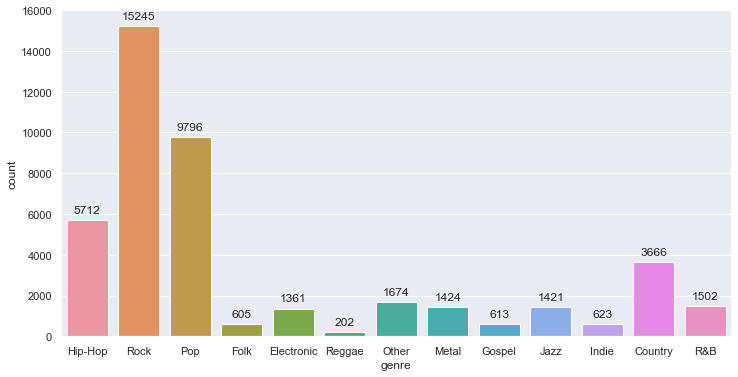

In [27]:
genres_complete = lyrics_df.genre
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(genres_complete, ax=ax)
add_value_labels(ax=ax)

#### **3.3.2 Release date**

Release dates are used to classify each song in different periods in an aggregated way, so that the analysis can focus on linguistic variations across these periods.

Unfortunately, approximately a third of release dates were missing, therefore I filled the NaNs in a coherent way according to each artist, both manually and automatically, dividing the criterion between artists that have no dates at all for their songs and artists that have at least some.

In [29]:
lyrics_df.loc[lyrics_df.release_date.isnull(), :].shape

(16460, 6)

In [29]:
# create "year" column. Month and Day are not useful for the purposes of the analysis
lyrics_df.loc[:, "year"] = None
lyrics_df.loc[lyrics_df.release_date.notnull(), "year"] = \
        lyrics_df.loc[lyrics_df.release_date.notnull(), "release_date"].apply(lambda date: datetime.strptime(date, "%Y-%m-%d").year)

In [30]:
# set to None any year before 1900 and greater than 2020 --> clearly a mistake
lyrics_df = lyrics_df.astype({"year": float})
lyrics_df.loc[(lyrics_df.year < 1900) | (lyrics_df.year > 2020), "year"] = None

#### Artists with no dates at all

There are some artists for which no song has its release date. Since these amount to 74 musicians in total, I decided to annotate them by hand. 

The analysis is concerned, among other things, with the evolution over time of topics, writing styles and genres, where time is divided in multiple periods as explained above. As a consequence, the level of granularity provided by a manual annotation of the year of each song would not result in an increase of information for my purposes. 

Nonetheless, an ideal and coherent annotation would obviously take into account the years of activity of an artist. Therefore I decided to search for them on the web and then label the songs according to a uniform probability over the years of activity of each musician.
In this way, a song that has been released, say, in 1974, could maybe be annotated as 1979, but this would not influence my analysis which takes into account only aggregated periods.

In [32]:
# how many songs for each artist
all_year_nan_artists = []
for artist in lyrics_df.artist.unique():
    artist_df = lyrics_df.loc[(lyrics_df.artist == artist), :]
    artist_df_length = artist_df.loc[:, "year"].shape[0]
    count_year_nans = artist_df.loc[:, "year"].isnull().sum()
    # if n° NaNs equals n° of rows
    if count_year_nans == artist_df_length:
        all_year_nan_artists.append((artist, artist_df_length))
len(all_year_nan_artists)

74

In [33]:
all_year_nan_artists

[('7horse', 1),
 ('A. R. Rahman', 1),
 ('Andrew E', 2),
 ('Ariel Rivera', 5),
 ('Original Cast of "Cats"', 20),
 ('Cedarmont Kids', 8),
 ('Dr. Tumi', 2),
 ('December Avenue', 1),
 ('Edith Piaf', 3),
 ('Fairport Convention', 46),
 ('Frankie Laine', 35),
 ('Frazey Ford', 17),
 ('Gary Valenciano', 16),
 ('Soweto Gospel Choir', 1),
 ('Gipsy Kings', 1),
 ('Glenn Fredly', 1),
 ('Gerry And The Pacemakers', 35),
 ('Gyroscope', 32),
 ('Irish Rovers', 25),
 ('The Irish Descendants', 3),
 ('Imago', 1),
 ('iLe', 1),
 ('Iyeoka', 10),
 ('Johnny Rebel', 2),
 ('JAY-R', 2),
 ('James Weldon Johnson', 2),
 ('Kamikazee', 1),
 ('Luciano Pavarotti', 9),
 ('Lynda Randle', 4),
 ('Martin Nievera', 21),
 ('Mocca', 26),
 ('Nawab', 1),
 ('Neha Kakkar', 1),
 ('Nana Mouskouri', 32),
 ('Opus', 3),
 ('The Phantom of the Opera (Original London Cast)', 1),
 ('Petra', 70),
 ('Quindon Tarver', 2),
 ('Queen Ifrica', 2),
 ('Question Mark & The Mysterians', 2),
 ('Qntal', 3),
 ('Quorthon', 22),
 ('Quincy Punx', 39),
 ('The 

##### Assign year to each song according to a uniform probability over years of activity of artist


In [34]:
artist_years_mapping = {
    '7horse': np.random.choice([year for year in range(2011, 2021)], size=1),
    'A. R. Rahman': np.random.choice([year for year in range(1992, 2021)], size=1),
    'Andrew E': np.random.choice([year for year in range(1985, 2021)], size=2),
    'Ariel Rivera': np.random.choice([year for year in range(1989, 2021)], size=5),
    'Original Cast of "Cats"': 2019*np.ones(shape=20),
    'Cedarmont Kids': np.random.choice([year for year in range(1993, 2000)], size=8),
    'Dr. Tumi': np.random.choice([year for year in range(2010, 2021)], size=2),
    'December Avenue': np.random.choice([year for year in range(2007, 2021)], size=1),
    'Edith Piaf': np.random.choice([year for year in range(1935, 1964)], size=3),
    'Fairport Convention': np.random.choice([year for year in range(1967, 2000)], size=46),
    'Frankie Laine': np.random.choice([year for year in range(1932, 1976)], size=35),
    'Frazey Ford': np.random.choice([year for year in range(2001, 2021)], size=17),
    'Gary Valenciano': np.random.choice([year for year in range(1982, 2021)], size=16),
    'Soweto Gospel Choir': np.random.choice([year for year in range(2005, 2019)], size=1),
    'Gipsy Kings': np.random.choice([year for year in range(1978, 2019)], size=1),
    'Glenn Fredly': np.random.choice([year for year in range(1995, 2021)], size=1),
    'Gerry And The Pacemakers': np.random.choice([year for year in range(1959, 1974)], size=35),
    'Gyroscope': np.random.choice([year for year in range(1997, 2021)], size=32),
    'Irish Rovers': np.random.choice([year for year in range(1967, 2012)], size=25),
    'The Irish Descendants': np.random.choice([year for year in range(1991, 2007)], size=3),
    'Imago': np.random.choice([year for year in range(1997, 2021)], size=1),
    'iLe': np.random.choice([year for year in range(2004, 2021)], size=1),
    'Iyeoka': np.random.choice([year for year in range(1996, 2021)], size=10),
    'Johnny Rebel': np.random.choice([year for year in range(1966, 2003)], size=2),
    'JAY-R': np.random.choice([year for year in range(1997, 2021)], size=2),
    'James Weldon Johnson': np.random.choice([year for year in range(1940, 1960)], size=2),
    'Kamikazee': np.random.choice([year for year in range(2000, 2015)], size=1),
    'Luciano Pavarotti': np.random.choice([year for year in range(1980, 2000)], size=9),
    'Lynda Randle': np.random.choice([year for year in range(2003, 2016)], size=4),
    'Martin Nievera': np.random.choice([year for year in range(1982, 2021)], size=21),
    'Mocca': np.random.choice([year for year in range(1997, 2021)], size=26),
    'Nawab': np.array([2019]),
    'Neha Kakkar': np.random.choice([year for year in range(2006, 2021)], size=1),
    'Nana Mouskouri': np.random.choice([year for year in range(1958, 2008)], size=32),
    'Opus': np.random.choice([year for year in range(1973, 2004)], size=3),
    'The Phantom of the Opera (Original London Cast)': np.array([1988]),
    'Petra': np.random.choice([year for year in range(1973, 2006)], size=70),
    'Quindon Tarver': np.random.choice([year for year in range(1996, 2021)], size=2),
    'Queen Ifrica': np.random.choice([year for year in range(1995, 2021)], size=2),
    'Question Mark & The Mysterians': np.random.choice([year for year in range(1966, 2000)], size=2),
    'Qntal': np.random.choice([year for year in range(1991, 2021)], size=3),
    'Quorthon': np.random.choice([year for year in range(1984, 2004)], size=22),
    'Quincy Punx': np.random.choice([year for year in range(1990, 2021)], size=39),
    'The Quakes': np.random.choice([year for year in range(1986, 2021)], size=1),
    'Reed Foehl': np.random.choice([year for year in range(2004, 2021)], size=1),
    'Sugar free': np.random.choice([year for year in range(2000, 2021)], size=1),
    'Silent Sanctuary': np.random.choice([year for year in range(2001, 2021)], size=1),
    'Songs For Children': np.random.choice([year for year in range(1980, 2021)], size=2),
    'Samsons': np.random.choice([year for year in range(1977, 2002)], size=21),
    'Toni Gonzaga': np.random.choice([year for year in range(2001, 2021)], size=10),
    'Ted Gärdestad': np.random.choice([year for year in range(1972, 1994)], size=6),
    'Typecast': np.random.choice([year for year in range(1999, 2021)], size=32),
    'Urban Dub': np.random.choice([year for year in range(2000, 2021)], size=22),
    'US Marine Corps': np.random.choice([year for year in range(1940, 2021)], size=1),
    'The Undertones': np.random.choice([year for year in range(1974, 2013)], size=26),
    'Velasquez Regine': np.random.choice([year for year in range(1986, 2021)], size=33),
    'Vaya Con Dios': np.random.choice([year for year in range(1986, 2009)], size=45),
    'Valli Frankie': np.random.choice([year for year in range(1953, 2021)], size=2),
    'Chorus of Winnie The Pooh': np.random.choice([year for year in range(2000, 2021)], size=1),
    'Wolfgang': np.random.choice([year for year in range(1992, 2021)], size=10),
    'The Wolfe Tones': np.random.choice([year for year in range(1963, 2021)], size=10),
    'X Factor (UK)': np.random.choice([year for year in range(2010, 2021)], size=4),
    'X-Perience': np.random.choice([year for year in range(1995, 2007)], size=20),
    'Ximena Sarinana': np.random.choice([year for year in range(1994, 2021)], size=10),
    'X-Pose': np.array([2019]),
    'xikidi': np.array([2015]),
    'Xiao Yu': np.random.choice([year for year in range(2003, 2021)], size=1),
    'Xasthur': np.random.choice([year for year in range(1995, 2021)], size=14),
    'Xmal Deutschland': np.random.choice([year for year in range(1980, 1990)], size=3),
    'x factor finalists': np.random.choice([year for year in range(2010, 2021)], size=1),
    'Yngwie Malmsteen': np.random.choice([year for year in range(1978, 2021)], size=67),
    'Yusuf Islam': np.random.choice([year for year in range(1995, 2017)], size=20),
    'Yiruma': np.random.choice([year for year in range(2001, 2021)], size=1),
    'zain bhikha': np.random.choice([year for year in range(1990, 2021)], size=2),
}

As an example of the result, Yusuf Islam (previously known as Cat Stevens) has been musically active (publising albums) under this name from 1995 to 2017. Indeed, after he became muslim in 1977 he changed his name and stopped performing from 1980 to 1995. The labels obtained with the method described above are perfectly coherent with the musical activity of this artist.

In [35]:
lyrics_df.loc[lyrics_df.artist == "Yusuf Islam", :]

,artist,song,album,release_date,genre,lyrics,year
48494,Yusuf Islam,A' Is For Allah,Footsteps in the Light,NaN,Folk,"A' is for Allah, nothing but Allah Ba is the b...",NaN
48495,Yusuf Islam,Thinking 'Bout You,Roadsinger,NaN,Folk,"Islam When I hold her hand, I could fly zilli...",NaN
48496,Yusuf Islam,Heaven/Where True Love Goes,An Other Cup,NaN,Folk,The moment you walked inside my door I knew th...,NaN
48497,Yusuf Islam,Don't Let Me Be Misunderstood,An Other Cup,NaN,Folk,"Baby, do you understand me now Sometimes I fee...",NaN
48498,Yusuf Islam,Roadsinger,Roadsinger,NaN,Folk,"Islam Roadsinger came to town, long cape and ...",NaN
48499,Yusuf Islam,Welcome Home,Roadsinger,NaN,Folk,"Saw a sign on the path ""All seekers this way"" ...",NaN
48500,Yusuf Islam,Maybe There's A World,An Other Cup,NaN,Folk,"I have dreamt of a place and time,where nobody...",NaN
48501,Yusuf Islam,I Think I See The Light,An Other Cup,NaN,Folk,"I used to trust nobody, trusting even less the...",NaN
48502,Yusuf Islam,Everytime I Dream,Roadsinger,NaN,Folk,Islam Every time I dream I keep seeing street...,NaN
48503,Yusuf Islam,Midday,NaN,NaN,Folk,I like to take a walk out in the midday Checki...,NaN


In [36]:
for artist, years in tqdm(artist_years_mapping.items()): 
    lyrics_df.loc[lyrics_df.artist == artist, "year"] = years

100%|██████████| 74/74 [00:00<00:00, 153.67it/s]


In [37]:
lyrics_df.loc[lyrics_df.artist == "Yusuf Islam", :]

,artist,song,album,release_date,genre,lyrics,year
48494,Yusuf Islam,A' Is For Allah,Footsteps in the Light,NaN,Folk,"A' is for Allah, nothing but Allah Ba is the b...",2001.0
48495,Yusuf Islam,Thinking 'Bout You,Roadsinger,NaN,Folk,"Islam When I hold her hand, I could fly zilli...",2013.0
48496,Yusuf Islam,Heaven/Where True Love Goes,An Other Cup,NaN,Folk,The moment you walked inside my door I knew th...,1995.0
48497,Yusuf Islam,Don't Let Me Be Misunderstood,An Other Cup,NaN,Folk,"Baby, do you understand me now Sometimes I fee...",2001.0
48498,Yusuf Islam,Roadsinger,Roadsinger,NaN,Folk,"Islam Roadsinger came to town, long cape and ...",2005.0
48499,Yusuf Islam,Welcome Home,Roadsinger,NaN,Folk,"Saw a sign on the path ""All seekers this way"" ...",1999.0
48500,Yusuf Islam,Maybe There's A World,An Other Cup,NaN,Folk,"I have dreamt of a place and time,where nobody...",2006.0
48501,Yusuf Islam,I Think I See The Light,An Other Cup,NaN,Folk,"I used to trust nobody, trusting even less the...",2016.0
48502,Yusuf Islam,Everytime I Dream,Roadsinger,NaN,Folk,Islam Every time I dream I keep seeing street...,2003.0
48503,Yusuf Islam,Midday,NaN,NaN,Folk,I like to take a walk out in the midday Checki...,1998.0


#### Artists with some years missing

As for artists with some years already annotated by *Genius*, I decided to follow a similar approach but with some modifications. Data from the *Genius* API is indeed highly reliable, therefore it makes sense to do a sort of "informed" labelling which exploits current annotation.

In this sense, the procedure below takes all the songs for each artist and looks at the annotated years, computing the minimum, maximum and mean year to follow this logic: 
- if the mean year is also the median year, we label the songs according to a uniform probability distribution over the years of activity;
- if the number of annotated years preceding the mean year is larger, it is reasonable to assume that the artist was more active before the mean year (since we have more data), therefore we label the songs according to a probability distribution with more mass on the first half of the years of activity;
- conversely, we label the songs according to a probability distribution with more mass on the second half of the years of activity.

In [38]:
example = lyrics_df.loc[lyrics_df.artist == "Elton John", :]

In [39]:
example_index = example.loc[example.year.isnull(), :].index
example_index

Int64Index([10450, 10455, 10462, 10473, 10478, 10489, 10492, 10494, 10499,
            10501, 10505, 10514, 10515, 10520, 10523],
           dtype='int64')

In [40]:
example.loc[example.year.isnull(), :]

,artist,song,album,release_date,genre,lyrics,year
10450,Elton John,Rocket Man,NaN,NaN,Rock,She packed my bags last night pre-flight Zero ...,NaN
10455,Elton John,Can You Feel the Love Tonight,NaN,NaN,Rock,There's a calm surrender To the rush of day Wh...,NaN
10462,Elton John,I Guess That's Why They Call It The Blues,Too Low for Zero,NaN,Rock,Don't wish it away Don't look at it like it's...,NaN
10473,Elton John,Mona Lisas And Mad Hatters,NaN,NaN,Rock,We wanted to do a love song for New York City....,NaN
10478,Elton John,Your Song (Live),NaN,NaN,Rock,It's a little bit funny this feeling inside I'...,NaN
10489,Elton John,Sad Songs (say So Much),Breaking Hearts,NaN,Rock,Guess there are times when we all need to sha...,NaN
10492,Elton John,Blue Eyes,Jump Up!,NaN,Rock,"Blue eyes Baby's got blue eyes Like a deep, b...",NaN
10494,Elton John,Candle In The Wind (Live),NaN,NaN,Rock,Goodbye Norma Jean Though I never knew you at ...,NaN
10499,Elton John,Original Sin,Songs from the West Coast,NaN,Rock,"Oh, it's carnival night And they're stringing...",NaN
10501,Elton John,Blessed,Made in England,NaN,Rock,"Hey you, you're a child in my head You haven'...",NaN


In [41]:
int(example.year.min()), int(example.year.max()), int(example.year.mean())

(1969, 2018, 1981)

In [42]:
for artist in tqdm(lyrics_df.loc[lyrics_df.year.isnull()].artist.unique()):
    artist_df = lyrics_df.loc[lyrics_df.artist == artist, :]
    nans_count = artist_df.loc[artist_df.year.isnull(), :].shape[0]
    min_year, max_year, mean_year = int(artist_df.year.min()), int(artist_df.year.max()), int(artist_df.year.mean())
    years = [year for year in range(min_year, max_year+1)]
    count_first_half = artist_df.loc[(artist_df.year.notnull()) & (artist_df.year < mean_year), :].shape[0]
    count_second_half = artist_df.loc[(artist_df.year.notnull()) & (artist_df.year >= mean_year), :].shape[0]
    if len(years) == 1:
        probabilities = [1]
    elif count_first_half > count_second_half:
        probabilities = [0.75/(len(years)//2) for i in range(len(years)//2)] + [0.25/(len(years) - (len(years)//2)) for i in range(len(years) - (len(years)//2))]
    elif count_first_half < count_second_half:
        probabilities = [0.25/(len(years)//2) for i in range(len(years)//2)] + [0.75/(len(years) - (len(years)//2)) for i in range(len(years) - (len(years)//2))]
    else:
        probabilities = [1/(len(years)) for i in range(len(years))]
    nans_filler = np.random.choice(years, size=nans_count, p=probabilities)
    lyrics_df.loc[(lyrics_df.year.isnull()) & (lyrics_df.artist == artist), "year"] = nans_filler

100%|██████████| 807/807 [00:12<00:00, 65.41it/s]


In [43]:
lyrics_df.loc[example_index, :]

,artist,song,album,release_date,genre,lyrics,year
10450,Elton John,Rocket Man,NaN,NaN,Rock,She packed my bags last night pre-flight Zero ...,1978.0
10455,Elton John,Can You Feel the Love Tonight,NaN,NaN,Rock,There's a calm surrender To the rush of day Wh...,1971.0
10462,Elton John,I Guess That's Why They Call It The Blues,Too Low for Zero,NaN,Rock,Don't wish it away Don't look at it like it's...,1992.0
10473,Elton John,Mona Lisas And Mad Hatters,NaN,NaN,Rock,We wanted to do a love song for New York City....,1998.0
10478,Elton John,Your Song (Live),NaN,NaN,Rock,It's a little bit funny this feeling inside I'...,1988.0
10489,Elton John,Sad Songs (say So Much),Breaking Hearts,NaN,Rock,Guess there are times when we all need to sha...,1980.0
10492,Elton John,Blue Eyes,Jump Up!,NaN,Rock,"Blue eyes Baby's got blue eyes Like a deep, b...",1997.0
10494,Elton John,Candle In The Wind (Live),NaN,NaN,Rock,Goodbye Norma Jean Though I never knew you at ...,1977.0
10499,Elton John,Original Sin,Songs from the West Coast,NaN,Rock,"Oh, it's carnival night And they're stringing...",1981.0
10501,Elton John,Blessed,Made in England,NaN,Rock,"Hey you, you're a child in my head You haven'...",1998.0


#### **3.4 Write cleaned and annotated dataset**

In [49]:
lyrics_df.shape

(43844, 7)

In [50]:
lyrics_df = lyrics_df.astype({"artist": str, "song": str, "album": str, 
                             "release_date": str, "genre": str, "lyrics": str, "year": int})

In [51]:
lyrics_df.to_csv("./data/lyrics_cleaned.csv", index=False)

In [2]:
lyrics_df = pd.read_csv('./data/lyrics_cleaned.csv')
lyrics_df.shape

(43844, 7)

## <center>**4. Preprocessing**</center>

In [3]:
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.corpus import stopwords
from nltk import Counter
import spacy
nlp = spacy.load("en")

### LyricsPreprocessing CLASS

In order to make everything reusable (and also more readable), I wrote a Class which acts as a wrapper around the preprocessing tools that we saw during lectures, adapting them to the needs of my analysis, providing more flexibility and adding some more features.

Various methods have been implemented to cover lowercasing, numbers replacement, punctuation removal, tokenization, lemmatization, POS tagging and collocations discovery. Since some steps took some time to finish, I used the *pickle* module to save results for later use.

In [4]:
class LyricsPreprocessing():
    
    
    def __init__(self, lyrics_df):
        
        self.lyrics_df = lyrics_df
        
        
    def preliminary_preprocessing(self, lyrics_df=None, replace_number_with="0", every_digit=True):
        
        if lyrics_df is None:
            lyrics_df = self.lyrics_df
        
        # lowercase
        print("Converting to lower case ...", flush=True)
        lyrics_df.loc[:, "lyrics"] = lyrics_df.lyrics.apply(lambda text: text.strip().lower())
        
        # replace numbers
        print(f"Replacing numbers with {replace_number_with} ...", flush=True)
        if every_digit:
            numbers = re.compile('[0-9]+')
        else:
            numbers = re.compile('[0-9]')
        
        lyrics_df.loc[:, "lyrics"] = lyrics_df.lyrics.apply(lambda text: re.sub(numbers, replace_number_with, text))
        
        return lyrics_df

    
    def tokenize(self, lyrics_df=None, save=False):
        
        if lyrics_df is None:
            lyrics_df = self.lyrics_df
        
        print("Tokenizing ...", flush=True)
        tokenized_corpus = [[token.text for token in nlp(lyrics)] for lyrics in tqdm(lyrics_df.loc[:, "lyrics"].to_list())]
        self.tokenized_corpus = tokenized_corpus
        
        if not save is False:
            self.save(tokenized_corpus, 'tokenized_corpus', how=save)
        
        return tokenized_corpus
    
    
    def core_preprocessing(self, lyrics_df, save=False):
        
        if lyrics_df is None:
            lyrics_df = self.lyrics_df
        
        lemmatized_corpus = []
        tagged_lemmatized_corpus = []
        trimmed_corpus = []
        tagged_trimmed_corpus = []
        for lyrics in tqdm(lyrics_df.loc[:, "lyrics"].to_list()):
            lemmas = []
            tagged_lemmas = []
            trimmed_lemmas = []
            tagged_trimmed_lemmas = []
            for token in nlp(lyrics):
                # remove all tokens with length <= 2
                if len(str(token)) > 2:
                    # lemmatize and get POS
                    lemma = token.lemma_
                    pos = token.pos_
                    lemmas.append(lemma)
                    tagged_lemmas.append(lemma + "_" + pos)
                    # keep only if POS in ['NOUN', 'VERB', 'ADJ', 'ADV','INTJ', 'X']
                    if pos in ['NOUN', 'VERB', 'ADJ', 'ADV', 'INTJ', 'X']:
                        trimmed_lemmas.append(lemma)
                        tagged_trimmed_lemmas.append(lemma + "_" + pos)
            lemmatized_corpus.append(lemmas)
            tagged_lemmatized_corpus.append(tagged_lemmas)
            trimmed_corpus.append(trimmed_lemmas)
            tagged_trimmed_corpus.append(tagged_trimmed_lemmas)
        
        self.lemmatized_corpus = lemmatized_corpus
        self.tagged_lemmatized_corpus = tagged_lemmatized_corpus
        self.trimmed_corpus = trimmed_corpus
        self.tagged_corpus = tagged_trimmed_corpus
        
        if not save is False:
            self.save(lemmatized_corpus, 'lemmatized_corpus', how=save)
            self.save(tagged_lemmatized_corpus, 'tagged_lemmatized_corpus', how=save)
            self.save(trimmed_corpus, 'trimmed_corpus', how=save)
            self.save(tagged_trimmed_corpus, 'tagged_trimmed_corpus', how=save)
    
    
    def syntactic_ngrams(self, lyrics_df=None, save=False):
        
        if lyrics_df is None:
            lyrics_df = self.lyrics_df
        
        syntactic_corpus = [["{}_{}".format(c.lemma_, c.head.lemma_) for c in nlp(lyrics) if len(str(c)) > 2] for lyrics in tqdm(lyrics_df.lyrics)]
        
        if not save is False:
            self.save(syntactic_corpus, 'syntactic_corpus', how=save)

           
    def join_collocations(self, preprocessed_corpus, most_common=20):
        
        # separate each lyrics with a space in order to avoid collocations between different songs
        words = []
        for idx, lyrics in enumerate(preprocessed_corpus):
            # not for the first
            if idx > 0:
                words.append(' ')
            for token in lyrics:
                words.append(token)
            
        finder = BigramCollocationFinder.from_words(words)
        bgm = BigramAssocMeasures()
        score = bgm.mi_like
        collocations = {'_'.join(bigram): pmi for bigram, pmi in finder.score_ngrams(score)}
        
        return Counter(collocations).most_common(most_common)
    
    
    def save(self, obj, filename, path='./data/', how='pickle'):
        
        if how == 'pickle':
            with open(os.path.join(path, filename + '.pickle'), 'wb') as pickled_obj:
                pickle.dump(obj, pickled_obj)
               

### **4.1 Preprocess**

In [5]:
lyrics_preprocess = LyricsPreprocessing(lyrics_df=lyrics_df)

In [6]:
# lowercase and replace numbers with special token
lyrics_cleaned = lyrics_preprocess.preliminary_preprocessing()

Converting to lower case ...
Replacing numbers with 0 ...


In [7]:
lyrics_cleaned.iloc[29767, :]

artist                                                 Pink Floyd
song                                               Lost For Words
album                                           The Division Bell
release_date                                           1994-03-28
genre                                                        Rock
lyrics          i was spending my time in the doldrums i was c...
year                                                         1994
Name: 29767, dtype: object

In [8]:
lyrics_preprocess.core_preprocessing(lyrics_cleaned, save='pickle')

100%|██████████| 43844/43844 [54:38<00:00, 14.56it/s]  


In [8]:
lyrics_preprocess.syntactic_ngrams(lyrics_cleaned, save='pickle')

100%|██████████| 43844/43844 [59:04<00:00, 11.92it/s]  


### **4.2 Statistics**

#### **4.2.1 Tokens**

In [9]:
tokenized_corpus = lyrics_preprocess.tokenize(lyrics_cleaned, save='pickle')

Tokenizing ...


100%|██████████| 43844/43844 [52:08<00:00, 14.66it/s]  


#### **4.2.2 Types** 

### **4.3 Load pickled preprocessed corpuses** 

In [9]:
with open('./data/lemmatized_corpus.pickle', 'rb') as pickled_object:
    lemmatized_corpus = pickle.load(pickled_object)

with open('./data/tagged_lemmatized_corpus.pickle', 'rb') as pickled_object:
    tagged_lemmatized_corpus = pickle.load(pickled_object)

with open('./data/trimmed_corpus.pickle', 'rb') as pickled_object:
    trimmed_corpus = pickle.load(pickled_object)

with open('./data/tagged_trimmed_corpus.pickle', 'rb') as pickled_object:
    tagged_trimmed_corpus = pickle.load(pickled_object)
    
with open('./data/syntactic_corpus.pickle', 'rb') as pickled_object:
    syntactic_corpus = pickle.load(pickled_object)

#### An example

In [10]:
print(lyrics_cleaned.loc[29767, "artist"], '-', lyrics_cleaned.loc[29767, "song"], '\n')
print('lemmatized corpus:', '\t', lemmatized_corpus[29767][:7])
print('taggedlemmatized corpus:', tagged_lemmatized_corpus[29767][:7])
print('trimmed corpus:', '\t', trimmed_corpus[29767][:7])
print('tagged trimmed corpus:', '\t', tagged_trimmed_corpus[29767][:7])
print('syntactic corpus:', '\t', syntactic_corpus[29767][:7])

Pink Floyd - Lost For Words 

lemmatized corpus: 	 ['be', 'spend', 'time', 'the', 'doldrums', 'be', 'catch']
taggedlemmatized corpus: ['be_AUX', 'spend_VERB', 'time_NOUN', 'the_DET', 'doldrums_NOUN', 'be_AUX', 'catch_VERB']
trimmed corpus: 	 ['spend', 'time', 'doldrums', 'catch', 'cauldron', 'hate', 'feel']
tagged trimmed corpus: 	 ['spend_VERB', 'time_NOUN', 'doldrums_NOUN', 'catch_VERB', 'cauldron_NOUN', 'hate_NOUN', 'feel_VERB']
syntactic corpus: 	 ['be_spend', 'spend_spend', 'time_spend', 'the_doldrums', 'doldrums_in', 'be_catch', 'catch_doldrums']


## <center>**5. TFIDF Analysis**</center>

In this section I used TFIDF analysis to get the most important words and n-grams in order to get a sense of what the songs talk about in general and how artists syntactically relate words through their writing style.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF

### LyricsTFIDF CLASS 

In [12]:
class LyricsTFIDF:
    
    
    def __init__(self, lyrics_df, preprocessed_corpus):
        
        self.lyrics_df = lyrics_df
        self.preprocessed_corpus = preprocessed_corpus
        self.tfidf_matrix = None
    
    
    def fit_transform(self, 
                      preprocessed_corpus=None, 
                      compute_constituents=False,
                      save_attributes=True,
                      topn=20,
                      analyzer='word',
                      ngram_range=(1,1), 
                      doc_frequency=(0.001,0.75), 
                      stop_words_language='english', 
                      logarithmic=True, 
                      info=True):
        
        if preprocessed_corpus is None:
            preprocessed_corpus = self.preprocessed_corpus
        
        # preprocessed corpus is expected to be a list of list of tokens/lemmas
        if info:
            print("Joining tokens for each lyrics ...", flush=True)
        preprocessed_corpus = [" ".join(lyrics) for lyrics in tqdm(preprocessed_corpus)]
        
        # dict for dataframe
        data = {}
        
        # initialize
        if info:
            print("Fitting TFIDF vectorizer ...", flush=True)
        tfidf_vectorizer = TfidfVectorizer(analyzer=analyzer,
                                            ngram_range=ngram_range,
                                            min_df=doc_frequency[0], 
                                            max_df=doc_frequency[1], 
                                            stop_words=stop_words_language, 
                                            sublinear_tf=logarithmic
                                           )
        # fit-transform
        tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed_corpus)
    
        if save_attributes:
            self.tfidf_matrix = tfidf_matrix
            self.tfidf_vectorizer = tfidf_vectorizer
            
        data['ngram'] = tfidf_vectorizer.get_feature_names()
        data['tfidf'] = tfidf_matrix.sum(axis=0).A1
        
        if compute_constituents:
            if info:
                print("Fitting count vectorizer ...", flush=True)
            count_vectorizer = CountVectorizer(analyzer=analyzer,
                                                ngram_range=ngram_range,
                                                min_df=doc_frequency[0], 
                                                max_df=doc_frequency[1], 
                                                stop_words=stop_words_language, 
                                                sublinear_tf=logarithmic
                                               )
            count_matrix = count_vectorizer.fit_transform(preprocessed_corpus)
            
            data['tf'] = count_matrix.sum(axis=0).A1
            data['idf'] = tfidf_vectorizer_word.idf_
                
        # create DataFrame
        df = pd.DataFrame(data=data).sort_values("tfidf", ascending=False).reset_index(drop=True).loc[:topn, :]
        
        return df
        
        
    def tfidf_by_genre(self, genres, lyrics_df=None, preprocessed_corpus=None, **kwargs):
        
        if lyrics_df is None:
            lyrics_df = self.lyrics_df
        if preprocessed_corpus is None:
            preprocessed_corpus = self.preprocessed_corpus
        
        # check if input error
        for genre in genres:
            admissible = lyrics_df.genre.unique()
            if genre not in admissible:
                raise KeyError(f"{genre} is not an admissible genre")
        
        # initialize df to return
        df = pd.DataFrame()
        
        print("Fitting TFIDF vectorizer for all genres ...", flush=True)
        for genre in genres:

            genre_idxs = lyrics_df.loc[lyrics_df.genre == genre, "lyrics"].index
            genre_corpus = np.array(preprocessed_corpus)[genre_idxs].tolist()
            
            genre_df = self.fit_transform(preprocessed_corpus=genre_corpus, info=False, save_attributes=False, **kwargs)
            
            # add MultiIndex for genres
            genre_df.columns = pd.MultiIndex.from_product([[genre], genre_df.columns])
            
            df = pd.concat([df, genre_df], axis="columns")
        
        return df
    
    
    def matrix_factorization(self, method, n_components, tfidf_matrix=None):
        
        if tfidf_matrix is None:
            tfidf_matrix = self.tfidf_matrix
        
        if method == 'svd':
            svd = TruncatedSVD(n_components=n_components)
            U = svd.fit_transform(tfidf_matrix)
            S = svd.singular_values_
            V = svd.components_
            
            return U, S, V

        elif method == 'nmf':
            nmf = NMF(n_components=n_components, init='nndsvd', random_state=0)

            W = nmf.fit_transform(tfidf_matrix)
            H = nmf.components_
            
            return W, H
    
    
    def print_latent_topics(self, lower_dimensional_words, vocabulary=None, topn=5):
    
        if vocabulary is None:
            vocabulary = self.tfidf_vectorizer.get_feature_names()

        topic_words = ([[vocabulary[i] for i in np.argsort(t)[:-topn-1:-1]]
                        for t in lower_dimensional_words])
        
        return [', '.join(t) for t in topic_words]

### 5.1 Most important words

Given that the `trimmed_corpus` restricts the focus to crucial parts of the sentences, it is a good candidate for this analysis.

In [13]:
lyrics_tfidf = LyricsTFIDF(lyrics_df=lyrics_cleaned, preprocessed_corpus=trimmed_corpus)

#### **5.1.1 Whole corpus**

Words connected to love and emotions are unsurprisingly of central importance in the whole corpus ('love', 'baby', 'heart', 'feel'), but other terms like 'life', 'time', 'think' and 'way' hint also to the more general area of introspection and analysis of life experiences, which are all very much present in all types of songs. 'Day' and 'night' are also interesting since they could have either a proper temporal nuance or a more metaphoric one.

In [76]:
tfidf_whole_corpus = lyrics_tfidf.fit_transform(ngram_range=(1,1), doc_frequency=(0.001, 0.5), topn=20)
tfidf_whole_corpus

Joining tokens for each lyrics ...


100%|██████████| 43844/43844 [00:00<00:00, 241223.21it/s]

Fitting TFIDF vectorizer ...


,ngram,tfidf
0,love,1933.175291
1,say,1486.987418
2,come,1400.903199
3,make,1359.997496
4,time,1358.093903
5,yeah,1266.844007
6,let,1263.991387
7,want,1226.357716
8,feel,1187.808912
9,baby,1168.889552


#### **5.1.2 By genre**

Fitting the Tf-Idf vectorizer by genre, some common themes remain shared across all genres, but other interesting aspects come out more clearly. Where the Hip-Hop culture signals itself with links to the African American culture ('nigga') and with a more frequent use of bad words, genres like Jazz point us to the emotional sphere perhaps also in a metaphoric way ('dream'). Finally, words like 'die' and 'world' appear in the top 20 only in the Metal genre.

In [85]:
lyrics_tfidf.tfidf_by_genre(genres=["Hip-Hop", "Country", "Pop", "Rock", "Electronic", "Jazz", "R&B", "Metal"], 
                            topn=20, doc_frequency=(0.001, 0.5))

Fitting TFIDF vectorizer for all genres ...


100%|██████████| 1424/1424 [00:00<00:00, 215108.01it/s]


Hip-Hop             Country                Pop               Rock  \
     ngram       tfidf   ngram       tfidf  ngram       tfidf  ngram   
0     love  183.524047     say  121.577360    say  364.429292   love   
1    bitch  179.131209    make  115.724023   make  342.335679   just   
2     fuck  160.586920    time  115.271939    let  336.682519    say   
3     shit  157.108629    come  114.048598   time  328.274506   come   
4     want  152.147806     way  103.455282   baby  327.107120   time   
5     baby  144.699979   heart   98.821606   come  325.286014   make   
6    nigga  140.288962     let   94.823831   yeah  324.884974   want   
7     need  138.871779     day   91.959242   feel  321.917650    way   
8     like  137.480445    baby   89.235197   want  310.302656   feel   
9     girl  137.055314   think   89.194898  heart  286.696842    let   
10    feel  135.203577   night   89.031015    way  284.653719   tell   
11   right  133.836079    good   88.602374   need  274.346166   yeah   
12     man  133.144723    tell   88.081759   tell  270.268351    day   
13     way  131.899854  little   88.009324  think  264.975898  think   
14   think  130.574492    life   87.173053   life  250.879827   baby   
15   money  125.496814    want   86.725791    day  242.837539   life   
16    life  124.736377     man   84.080503  right  233.628161   away   
17    look  122.859185     old   83.466623   away  229.387777  heart   
18    good  120.117544    yeah   83.271785   look  229.270946   look   
19     day  109.233180   thing   82.900437  thing  228.107776  night   
20   thing  108.481447   leave   82.867664   good  224.267912   need   

               Electronic              Jazz               R&B             \
         tfidf      ngram      tfidf  ngram      tfidf  ngram      tfidf   
0   634.613972       love  62.298879   know  54.293496   baby  75.107418   
1   557.384048       just  45.757320   just  51.541578   yeah  60.870493   
2   525.069013       feel  45.442001    say  46.170014    say  55.287605   
3   499.635594       yeah  43.885254  heart  45.683109   want  54.871155   
4   495.832003       come  43.221988   come  43.751612   make  54.673336   
5   456.266302        let  43.009401   make  41.533278   come  54.567223   
6   437.587221       time  41.001723   time  38.842899    let  54.050483   
7   406.925697        say  40.201783    day  38.361279   time  49.972522   
8   405.271334       make  39.505870    way  35.868336   need  49.053217   
9   394.146192       want  37.953415    let  34.998077   tell  47.337540   
10  376.554949       baby  37.005069  dream  33.311067   girl  45.480114   
11  373.072408       tell  35.839365   tell  33.298962   feel  44.734647   
12  371.222946       need  33.291191  night  31.783895    way  44.728585   
13  369.141437      think  32.998540   life  30.268289  heart  41.738666   
14  365.292660        way  32.519736   baby  29.162014  right  40.995428   
15  352.068256       life  31.762152   feel  28.548144   good  39.777045   
16  350.519276       look  29.910813   want  28.514919  think  38.402696   
17  344.767826        day  29.506165   away  28.247048  night  38.384298   
18  341.256047      night  29.217219  thing  28.138429  thing  38.241661   
19  332.052915      heart  29.148473    eye  27.654558    day  38.204686   
20  327.018508      right  28.510747    man  27.257113   life  37.780105   

    Metal             
    ngram      tfidf  
0    know  50.571698  
1    just  42.086576  
2    come  41.671393  
3    time  41.554964  
4    life  40.982417  
5     way  35.895470  
6    make  35.892546  
7    love  35.747455  
8    away  35.467159  
9     say  35.152387  
10   feel  34.148966  
11   want  33.534283  
12    day  32.381764  
13    die  32.337184  
14    let  32.141556  
15    eye  31.709931  
16   live  31.241247  
17  leave  29.259639  
18  night  29.235622  
19   yeah  28.955679  
20  world  28.408740

### 5.2 Most important n-grams by genre

An analysis at the bigram/trigram level does not reveal much more additional information. Many word repetitions come out, which is totally coherent given that artists use them either to give a catchy end to verses or to follow the music rhythm.

In [86]:
lyrics_tfidf.tfidf_by_genre(genres=["Hip-Hop", "Country", "Pop", "Rock", "Electronic", "Jazz", "R&B", "Metal"], 
                            ngram_range=(2,3), topn=40, doc_frequency=(0.001, 0.5))

Fitting TFIDF vectorizer for all genres ...


100%|██████████| 1424/1424 [00:00<00:00, 285201.46it/s]


Hip-Hop                    Country                        Pop  \
             ngram      tfidf           ngram      tfidf           ngram   
0        yeah yeah  91.066513       love love  28.439079       yeah yeah   
1   yeah yeah yeah  53.561753       know know  21.132571       love love   
2        know know  50.703292       know love  20.614375       know know   
3        love love  43.913350       yeah yeah  20.451649  yeah yeah yeah   
4        yeah know  30.733985     break heart  18.204167       know love   
5         let know  30.303052       come home  17.304525         ooh ooh   
6        bad bitch  28.915210       love know  16.876161  love love love   
7          say say  26.486899       good time  15.481416       make feel   
8        just want  26.391704     say goodbye  15.455621       come come   
9          ooh ooh  26.229431      little bit  15.420304         let let   
10         hey hey  26.059337       know just  15.399001        let know   
11       know just  23.649728       come come  14.861777         hey hey   
12       come come  23.503433       love make  14.784583       baby baby   
13         let let  22.937049       fall love  14.165272       love know   
14      fuck bitch  22.519620        say love  14.069618         say say   
15     bitch bitch  22.264094       love just  13.834259        say love   
16  love love love  21.958121      hold tight  13.102285       want want   
17       know love  21.784554     just little  12.897348       fall love   
18       want want  21.319241       make feel  12.821387       know just   
19         hip hop  20.807621       close eye  12.379241       close eye   
20       fuck fuck  20.717676     good friend  12.172903     ooh ooh ooh   
21       just know  20.609542       long time  11.852847     say goodbye   
22     young nigga  20.406809       walk away  11.831402       want know   
23       make feel  19.807911  yeah yeah yeah  11.488050       know want   
24        know say  19.635470       time time  11.411872       just want   
25       time time  19.622729       make love  11.367907       love just   
26       girl know  19.346034        far away  11.270363        look eye   
27       yeah just  19.193100     little girl  11.124234        just let   
28       baby girl  19.107042       come true  11.118716  know know know   
29      bitch know  18.923525       long long  10.928631       walk away   
30       live life  18.638630        set free  10.919711       time time   
31         way way  18.581626       wind blow  10.915977       live life   
32       fall love  18.562257       tell love  10.856380       know feel   
33       know want  18.438950        look eye  10.642024     break heart   
34       baby baby  18.380044         old man  10.561838       make love   
35      nigga know  18.306774       feel good  10.551688        know say   
36  know know know  18.127832      night long  10.453935       love make   
37       know yeah  17.887974       true love  10.348616        far away   
38       make sure  17.519214     heart break  10.275121        love way   
39       just make  17.403575        hear say  10.170149       need love   
40     right right  16.996882         say say  10.000307       just know   

                          Rock                  Electronic             \
         tfidf           ngram       tfidf           ngram      tfidf   
0   122.509737       love love  148.175406       love love  16.021522   
1   118.246009       yeah yeah  143.534903       yeah yeah  13.025762   
2    98.734463       know know  136.910608       know know  12.447966   
3    72.253757       come come   93.848894  love love love  10.067719   
4    66.206203       time time   81.031815         ooh ooh   8.605772   
5    65.604642  yeah yeah yeah   80.237285       come come   8.479611   
6    60.768744         say say   80.141433     ooh ooh ooh   7.034894   
7    60.214178       know love   78.195684  yeah yeah yeah   6.834979   
8    58.1211

### 5.3 Most important syntactic n-grams by genre

Even if the English language has a somewhat more standard structure, writing styles used in songs can be much more free in order to accommodate music rhythm and create a nicer sound effect overall. It therefore makes sense to see if syntactic bigrams can give more information.

Unfortunately, as it can be seen below, a tfidf analysis of most important syntactic unigrams and bigrams seems not to bring much more knowledge.

In [14]:
lyrics_tfidf.preprocessed_corpus = syntactic_corpus

In [16]:
lyrics_tfidf.tfidf_by_genre(genres=["Hip-Hop", "Country", "Pop", "Rock", "Electronic", "Jazz", "R&B", "Metal"], 
                            ngram_range=(1,2), topn=20, doc_frequency=(0.001, 0.1))

Fitting TFIDF vectorizer for all genres ...


100%|██████████| 1424/1424 [00:00<00:00, 156005.98it/s]


Hip-Hop                Country                             Pop  \
             ngram      tfidf       ngram      tfidf                ngram   
0            yeah_  24.430818     love_be  23.116844       love_love pron   
1          love_be  23.365618   and_ pron  21.690576              love_in   
2        stop_stop  23.077034   find_find  20.572335  yeah_yeah yeah_yeah   
3          good_be  22.900178     like_be  20.520133            the_night   
4      nigga_nigga  22.685045     the_one  20.309538            hear_hear   
5        the_thing  22.497862  pron _with  20.254414         _say say_say   
6        money_get  22.401067       _with  20.254414                  _of   
7         and_know  21.929438   the_thing  20.108230              not_let   
8        find_find  21.781111       _want  19.803043                _like   
9   give_give pron  21.697100     time_be  19.769611             and_come   
10      nothing_be  21.639777     here_be  19.561262             pron _of   
11     watch_watch  21.477296  pron _want  19.424771           pron _like   
12         life_be  21.330444     what_be  19.111574              not_get   
13       the_bitch  21.324946   keep_keep  18.909266              be_know   
14        not_give  21.317730   pron pron  18.909180              ooh_ooh   
15            _ass  21.201868      one_be  18.756805          leave_leave   
16       pron _ass  21.138531     the_sun  18.734731               _leave   
17       hold_hold  21.113707   give_give  18.723332         see_see pron   
18          out_be  20.881455     well_be  18.636422            hold_hold   
19       right_now  20.780836     what_do  18.434025      believe_believe   
20       like_feel  20.736945   the_night  18.259315          pron _leave   

                             Rock                     Electronic            \
        tfidf               ngram      tfidf               ngram     tfidf   
0   56.113374             this_be  98.849628             love_be  8.165262   
1   54.246449                _for  98.545626           keep_keep  7.605743   
2   53.534575           pron _for  98.158364              and_go  7.342432   
3   50.600184           need_need  95.273314             time_be  7.271332   
4   50.191358             here_be  93.369765  not_know know_know  7.201933   
5   49.994281             love_be  91.896146          because_be  7.170954   
6   49.491945             the_one  90.073987            the_time  7.161557   
7   49.432148               _give  90.053509                and_  7.120808   
8   49.326728           hear_hear  89.931546             what_do  7.118975   
9   49.294056          pron _give  89.021193               _with  7.114623   
10  49.187332           the_night  88.320493           hear_hear  7.112283   
11  48.661185           find_find  87.906994               _need  7.078646   
12  48.220022           pron pron  87.564357             here_be  7.064732   
13  47.899396             what_do  86.355250             the_one  7.040112   
14  47.863627               _with  86.103500          pron _with  7.039557   
15  47.019347          pron _with  85.747736           and_ pron  7.031838   
16  46.941456               _come  85.311940           pron _eye  6.940928   
17  46.826924           keep_keep  83.416938                _eye  6.940928   
18  46.753082             the_sun  83.014334          pron _need  6.934925   
19  46.600283          pron _come  82.632768               be_go  6.745946   
20  46.565997  not_know know_know  81.909941               _come  6.730545   

              Jazz                         R&B                 Metal            
             ngram     tfidf             ngram     tfidf       ngram     tfidf  
0        pron pron  9.189288           love_in  8.037444     the_sky  8.691026  
1        want_want  8.923945           ooh_ooh  7.968594        _for  8.475134  
2         have_get  8.705445    want_want pron  7.851839   give_give  8.448832  
3   love_love pron  8.668902  have_get 

## <center>**6. Latent Topics from Matrix Factorization**</center> 

Even though the interpretation of topics is not an easy task, the lower-dimensional view of the terms gives us some fairly distinguishable sets of words. Numbers go from 1 to 10 and start from the top of the printed topics below.

Love and sentimental relations are again the most present, but perhaps from different perspectives:
- topic n.5 talks about love in a more sentimental and emotional way, with some words that point to physical and psychological sensations such as 'hold', 'forever', 'heart', 'need';
- topic n.3, instead, treats this theme more directly by mentioning the loved one ('baby', 'girl') and using interjections ('ooh', 'yeah', 'whoa') and qualitative adjectives ('crazy', 'good'). To me this seems a treatment of the theme which could be compatible with songs that target younger listeners on average.

Other interesting topics are the following:
- n.2 is made up of many bad words and links to volgarity and tangible goods ('money');
- n.6 probably refers to parents-children relations and their view from both sides;
- n.10 surely deals with dancing, partying and related;
- n.7 describes famous themes like the desire and hope of change, freedom and maybe implicitly refers to wars ('die', 'world');
- n.4 hints to common metaphoric descriptions of emotions through meteorological events ('rain', 'sun', ...) adjectives ('dark', 'light');



In [ ]:
lyrics_tfidf.preprocessed_corpus = trimmed_corpus
tfidf_whole_corpus = lyrics_tfidf.fit_transform(ngram_range=(1,1), doc_frequency=(0.001, 0.5), topn=20)

In [8]:
W, H = lyrics_tfidf.matrix_factorization(method='nmf', n_components=10)

In [10]:
lyrics_tfidf.print_latent_topics(H, topn=10)

['say, think, want, try, tell, time, thing, way, feel, make',
 'bitch, fuck, shit, nigga, money, ass, hit, niggas, gon, like',
 'baby, yeah, ooh, girl, hey, want, whoa, need, crazy, good',
 'eye, fall, light, sky, sun, heart, rain, shine, burn, dark',
 'love, heart, true, forever, need, kiss, hold, sweet, make, arm',
 'man, little, old, song, girl, good, boy, sing, woman, say',
 'life, live, world, die, forever, free, dream, hope, change, day',
 'long, night, day, come, home, wait, time, dream, way, lonely',
 'away, stay, walk, far, day, run, leave, today, say, fade',
 'let, tonight, hold, right, come, feel, dance, hand, tight, make']

## <center>**7. LDA**</center> 

In [ ]:
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary

### LyricsLda CLASS

In [2]:
class LyricsLda:
        
        
    def __init__(self, lyrics_df, preprocessed_corpus):
                
        self.lyrics_df = lyrics_df
        self.lyrics_df_shuffled = None
        self.preprocessed_corpus = preprocessed_corpus
        
        self.coherence_values = None
        self.model = None
        self.topic_corpus = None
        self.descriptors = None
        self.num_topics = None
        self.shuffled_corpus_idxs = None
    
    
    def create_lda_corpus(self, randomize=False, preprocessed_corpus=None, filter_extremes=(100, 0.1)):
        
        if preprocessed_corpus is None:
            corpus = self.preprocessed_corpus  #.copy() # copy necessary to avoid randomizing in place
        
        # randomize in order to guarantee coherent (diversity across genres) dev and eval datasets when choosing number of topics
        if randomize:
            print("Randomizing corpus ...")
            corpus = np.array(corpus)
            shuffled_idxs = np.arange(corpus.shape[0])
            random.shuffle(shuffled_idxs)
            self.shuffled_corpus_idxs = shuffled_idxs
            
            # RESHUFFLE CORPUS AND DF ACCORDINGLY
            corpus = corpus[shuffled_idxs].tolist()
            self.lyrics_df_shuffled = self.lyrics_df.iloc[shuffled_idxs, :].reset_index(drop=True)
            
        print("Creating dictionary ...")
        # read in instances and create Dictionary object w information about frequencies etc. 
        dictionary = Dictionary(corpus)
        # get rid of words that are too rare or too frequent
        dictionary.filter_extremes(no_below=filter_extremes[0], no_above=filter_extremes[1])
        
        #replace words by their numerical IDs and their frequency
        print("Creating model corpus ...", flush=True)
        lda_corpus = [dictionary.doc2bow(text) for text in tqdm(corpus)]
        # learn TFIDF values from corpus and transform raw frequencies into TFIDF
        tfidf_model = TfidfModel(lda_corpus)
        model_corpus = tfidf_model[lda_corpus]
        
        return corpus, model_corpus, dictionary
    
    
    def choose_num_topics(self, shuffled_corpus, model_corpus, dictionary, topics_range=(1, 20), dev_size=10000, eval_size=5000, alpha=0.5):
        
        coherence_values = []
        model_list = []

        dev_size = dev_size
        eval_size = eval_size
        
        print("Choosing topics ...", flush=True)
        for num_topics in tqdm(range(topics_range[0], topics_range[1])):
            model = LdaMulticore(corpus=model_corpus[:dev_size], id2word=dictionary, num_topics=num_topics, alpha=alpha)
            model_list.append(model)
            coherencemodel_umass = CoherenceModel(model=model, 
                                                  texts=shuffled_corpus[dev_size:dev_size+eval_size], 
                                                  dictionary=dictionary, 
                                                  coherence='u_mass')

            coherencemodel_cv = CoherenceModel(model=model, 
                                               texts=shuffled_corpus[dev_size:dev_size+eval_size], 
                                               dictionary=dictionary, 
                                               coherence='c_v')

            umass_score = coherencemodel_umass.get_coherence()
            cv_score = coherencemodel_cv.get_coherence()

            coherence_values.append((num_topics, umass_score, cv_score))
        
        self.coherence_values = coherence_values
        
        for coherence_value in coherence_values:
            print(coherence_value)
        
        return coherence_values
    
    
    def plot_coherence_values(self, coherence_values=None, topics_range=(1, 20), fig_size=(10, 5)):
        
        if coherence_values is None:
            coherence_values = self.coherence_values

        scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=fig_size)
        scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(topics_range[0], topics_range[1]))
        scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(topics_range[0], topics_range[1]))
        plt.show()
        
        return 
    
    
    def fit_transform(self, num_topics, model_corpus=None, dictionary=None, iterations=50, num_passes=10, num_updates=200, alpha=0.5):
        
        self.num_topics = num_topics
        
        # [1:] -> only need model corpus and dictionary
        if model_corpus is None:
            model_corpus, model_corpus_dict = self.create_lda_corpus(randomize=False)[1:]
            if dictionary is None:
                dictionary = model_corpus_dict
        
        # find chunksize to make about 200 updates
        num_passes = num_passes
        chunk_size = len(model_corpus) * num_passes/num_updates

        # fit
        model = LdaMulticore(num_topics=self.num_topics, # number of topics
                             corpus=model_corpus, # what to train on 
                             id2word=dictionary, # mapping from IDs to words
                             workers=min(10, multiprocessing.cpu_count()-1), # choose 10 cores, or whatever computer has
                             iterations=iterations, # maximum number of times the model loops over each document
                             passes=num_passes, # make this many passes over data
                             chunksize=chunk_size, # update after this many instances
                             alpha=alpha
                            )
        self.model = model
        
        # transform the data into topic distributions
        topic_corpus = model[model_corpus]
        self.topic_corpus = topic_corpus
        
        return topic_corpus
    
    
    def print_topics(self, num_topics=None, num_words=5):
        
        if num_topics is None:
            num_topics = self.num_topics
        
        # get the topic descritions
        topic_sep = re.compile(r"0\.[0-9]{3}\*") # getting rid of useless formatting
        # extract a list of tuples with topic number and descriptors from the model
        model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                        self.model.print_topics(num_topics=num_topics, num_words=num_words)]

        descriptors = []
        for i, m in model_topics:
            print(i+1, ", ".join(m[:num_words]))
            descriptors.append(", ".join(m[:num_words]).replace('"', ''))
        
        self.descriptors = descriptors
        
        return
        
    
    def period_column(self, lyrics_df=None):
        
        input_df = lyrics_df
        
        if lyrics_df is None:
            lyrics_df = self.lyrics_df
        
        def year_to_period(year):
            if int(year) < 1970:
                return "<70s"
            elif int(year) < 1980:
                return "70s-80s"
            elif int(year) < 1990:
                return "80s-90s"
            elif int(year) < 2000:
                return "90s-2000"
            elif int(year) < 2010:
                return "2000-2010"
            else:
                return ">=2010"
        
        lyrics_df.loc[:, "period"] = lyrics_df.year.apply(lambda year: year_to_period(year))
        
        if input_df is None:
            self.lyrics = lyrics_df
        else:
            self.lyrics_df_shuffled = lyrics_df
        
        return lyrics_df
    
    
    def aggregate_topics(self, target_category="genre", aggregate_period=False, topic_corpus=None, descriptors=None, limit=None):
        
        if topic_corpus is None:
            topic_corpus = self.topic_corpus
        if descriptors is None:
            descriptors = self.descriptors
        if limit is None:
            limit = self.lyrics_df.shape[0]
        
        target_category = target_category
        
        print(f"Aggregating topics by {target_category} ...", flush=True)
        # get a list of all the topic scores for each document
        scores = [[t[1] for t in topic_corpus[entry]] for entry in tqdm(range(limit))]
        # turn that into a data frame with N rows and K columns, each with the score of the corresponding topic
        topic_distros = pd.DataFrame(data=scores, columns=descriptors)
        # add the review category of each document (so we can aggregate)
        topic_distros[target_category] = self.lyrics_df[target_category][:limit]
        if aggregate_period:
            self.period_column()
            topic_distros["period"] = self.lyrics_df["period"][:limit]
        
        return topic_distros
    
    
    def plot_aggregated_topics(self, topic_distros, target_category="genre", aggregate_period=False, descriptors=None, include_subcategories=None, fig_size=(10, 5)):
        
        if descriptors is None:
            descriptors = self.descriptors
        if include_subcategories is None:
            include_subcategories = self.lyrics_df.loc[:, target_category].unique()
        num_subcategories = len(include_subcategories)
        
        # aggregate topics by categories
        aggregate_by_category = topic_distros[topic_distros[target_category].isin(include_subcategories)]
        if aggregate_period:
            aggregate_by_category = aggregate_by_category.groupby([target_category, "period"]).mean()
        else:
            aggregate_by_category = aggregate_by_category.groupby(target_category).mean()

        # plot the graph
        if (num_subcategories == 1):
            subcategory = include_subcategories[0]
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fig_size)
            if aggregate_period:
                ordered_periods = [period for period in ["<70s", "70s-80s", "80s-90s", "90s-2000", "2000-2010", ">=2010"]\
                            if period in aggregate_by_category.loc[subcategory, descriptors].index]
                aggregate_by_category.loc[subcategory, descriptors].loc[ordered_periods, :].plot.bar(ax=ax)
            else:
                aggregate_by_category[descriptors].plot.bar(ax=ax)

            handles, labels = ax.get_legend_handles_labels()
            labels = [" ".join(topic_words.split()[:5]) for topic_words in labels]
            plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1.0, 0.5))
            ax.set_title(subcategory, fontdict={'fontsize': 12, 'fontweight':20})
            plt.show()
        else:
            print("Plotting for each group ...", flush=True)
            fig, ax = plt.subplots(nrows=num_subcategories, ncols=1, figsize=fig_size)#(fig_size[0]*num_subcategories, fig_size[1]*num_subcategories))
            for idx, subcategory in enumerate(include_subcategories):
                # sort periods to print them in order
                ordered_periods = [period for period in ["<70s", "70s-80s", "80s-90s", "90s-2000", "2000-2010", ">=2010"]\
                                   if period in aggregate_by_category.loc[subcategory, descriptors].index]
                aggregate_by_category.loc[subcategory, descriptors].loc[ordered_periods, :].plot.bar(ax=ax[idx])
                ax[idx].get_legend().remove()
                ax[idx].set_title(subcategory, fontdict={'fontsize': 12, 'fontweight':20})

            handles, labels = ax[idx].get_legend_handles_labels()
            labels = [" ".join(topic_words.split()[:5]) for topic_words in labels]
            fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.15, 0.5))
            fig.tight_layout(pad=3)
            plt.show()  
        
        return   

### **7.1 Choose number of topics and fit LDA model**

In [22]:
lyrics_lda = LyricsLda(lyrics_df=lyrics_cleaned, preprocessed_corpus=trimmed_corpus)

In [23]:
shuffled_corpus, lda_corpus, dictionary = lyrics_lda.create_lda_corpus(randomize=True, filter_extremes=(100, 0.5))

Randomizing corpus ...
Creating dictionary ...
Creating model corpus ...


100%|██████████| 43844/43844 [00:04<00:00, 10012.09it/s]


During the analysis of latent dimensions in the last section, only 7 out of 10 topics were clearly interpretable. Taking this into consideration, I decided to choose the number of topics for LDA plotting coherence values from 5 to 15 topics. As it can be seen below, CV score as a clear peak at 8 topics, while UMass decreases as the number gets larger. Given that the value of UMass at 8 topics is not too far from the peak (5 topics), 8 seems the most reasonable choice. 

As for the alpha parameter of the Dirichlet Process, since this controls the level of concentration of each document around a few topics, I decided to set it to a low value. My prior knowledge suggests me that many topics are probably shared across different genres, therefore I would like to contrast the data with a prior that could allow each genre to exhibit mostly its peculiar topics. 

In [25]:
coherence_values = lyrics_lda.choose_num_topics(shuffled_corpus=shuffled_corpus, 
                                                model_corpus=lda_corpus, dictionary=dictionary, topics_range=(5, 15), alpha=0.1)

Choosing topics ...


100%|██████████| 10/10 [03:23<00:00, 21.06s/it]

(5, -0.914060718404409, 0.3295790365890756)
(6, -0.9189080049539138, 0.32667122669732196)
(7, -0.9346524060488409, 0.33178352848909126)
(8, -0.9599265587367461, 0.33525819498207243)
(9, -0.989561612040592, 0.32497796804923673)
(10, -0.9979615540482742, 0.32801035516636623)
(11, -0.9890528138533218, 0.3249204014084702)
(12, -1.011343603904081, 0.32625551270973013)
(13, -1.0021751398759526, 0.32875516321747394)
(14, -1.0428046046357125, 0.3234765268637779)


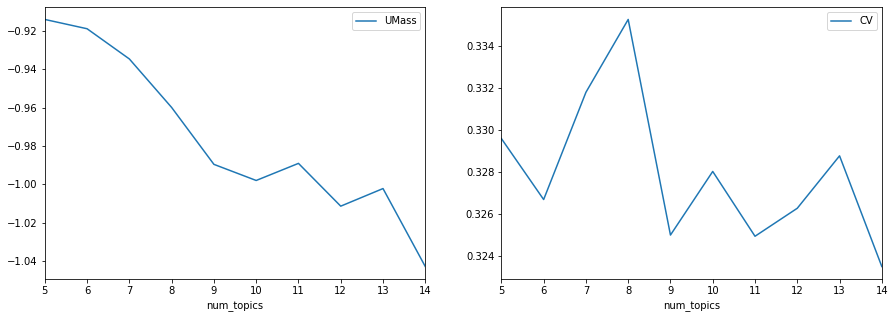

In [26]:
lyrics_lda.plot_coherence_values(fig_size=(15,5), topics_range=(5, 15))

In [30]:
topic_corpus = lyrics_lda.fit_transform(num_topics=8, iterations=100, alpha=0.1)

Creating dictionary ...
Creating model corpus ...


100%|██████████| 43844/43844 [00:04<00:00, 10737.14it/s]


The topics that come out from Latent Dirichlet Allocation tend to reflect what we saw in the previous section:
- **n.6** is linked with the use of explicit language;
- **n.4** with dancing and music as a driver of entertainment;
- **n.1** contains a lot of references to natural elements and meteorological events, which again could be used as metaphoric descriptions of emotions;
- **n.2** and **n.8** treat the love theme with different nuances;
- **n.3** is typical of Rock 'n Roll, whose themes, especially if we consider the 70s-80s, revolve around the life of the working class, the riding of cars or motorbikes and emotions treated as a fire that comes from the inside;
- **n.5** describes again parents-children relations and life as a child;
- **n.7** is connected to the desire of freedom and change, both physical and psychological, and also to some concepts probably related to the Gospel genre ('glory', 'praise',...)


In [31]:
lyrics_lda.print_topics(num_topics=8, num_words=10)

1 "sun", "sky", "sing", "rain", "shine", "wind", "fly", "sea", "star", "blue"
2 "goodbye", "forever", "miss", "sorry", "hurt", "tear", "together", "inside", "alive", "pain"
3 "whoa", "roll", "ride", "town", "rock", "hey", "burn", "fire", "drink", "tonight"
4 "ooh", "tonight", "dance", "feeling", "anymore", "enough", "care", "hurt", "touch", "hey"
5 "feat", "daddy", "mama", "gun", "mother", "hey", "woman", "son", "pretty", "poor"
6 "bitch", "nigga", "gon", "ass", "hit", "niggas", "hey", "hoe", "pussy", "tryna"
7 "soul", "free", "save", "praise", "fear", "lift", "glory", "power", "rise", "faith"
8 "hey", "please", "alright", "beautiful", "else", "woman", "remember", "lonely", "sometimes", "wrong"


### **7.2 Aggregate by genre and period**

As outlined in the research question (Section 2), I would like to see if the distribution of topics over different time period changes within each musical genre. This is interesting because it could provide a dynamic characterization of how artists changed their lyrics subjects and, since I downloaded the 'most popular' ones, an idea of how people's major musical tastes have shaped over the years.

Towards this end, the method `self.period_column()` in the `LyricsLda` class classifies each song in one of six different time periods: <70s, 70s-80s, 80s-90s, 90s-2000, 2000-2010, >=2010. This method is called by `self.aggregate_topics()`, which in turn aggregates the topics distributions by genre and time period.

In [32]:
topic_distros_genre_period = lyrics_lda.aggregate_topics(aggregate_period=True)

Aggregating topics by genre ...


100%|██████████| 43844/43844 [00:45<00:00, 972.78it/s] 


### **7.3 Plot the topics distributions**

A coherent analysis over different time periods needs to be based on data that are as homogeneous as possible in terms of number of instances within each group, otherwise the conclusions reached could be strongly unreliable. As a consequence I decided to plot and analyze only genres for which this property is respected and I have enough data, namely Rock, Hip-Hop, Pop and Country. 

#### **7.3.1 Hip-Hop**

The Hip-Hop genre shows a clear dominance of topic n.6 (brown bar), the one linked to explicit content and obscene language. Moreover, it is now clearer why the same topic contained words like 'nigga': Hip-Hop is indeed an integral part of the Afro-American culture, from which it was mainly born and from which draws the most influential artists. 

Obviously, what said above does not mean that those are the only topics treated by in this musical genre. My choice of the alpha parameter was indeed aimed at bringing out the more distinctive characteristics, the ones that differentiate one genre from another, and it is exactly in this way that it has to be interpreted.

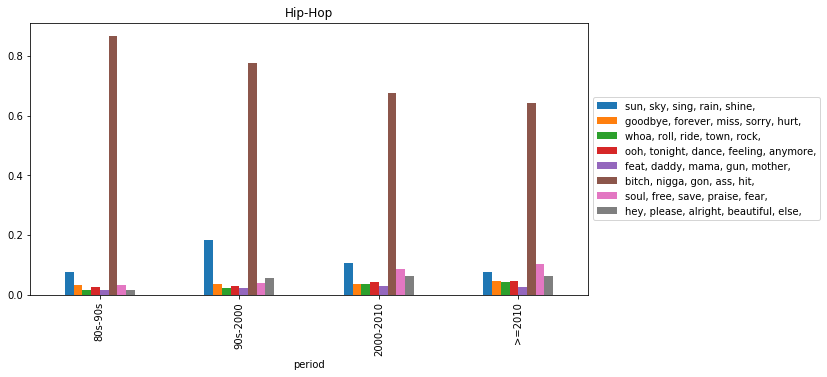

In [35]:
lyrics_lda.plot_aggregated_topics(topic_distros=topic_distros_genre_period, aggregate_period=True, 
                                  include_subcategories=["Hip-Hop"], fig_size=(10, 5))

Note that Hip-Hop does not have <70s and 70s-80s because there were no observations for these periods. It is indeed around the late 70s that this genre became popular.

#### **7.3.2 Pop**

Two are the most interesting features of Pop music coming out from the graph below:
1. first of all, there seems to be an increasing tendency to use explicit language in the lyrics of the songs (see the brown bar), and this is especially true for the last two decades. From <70s to >=2010, the probability value of topic n.6 within the distribution passed from around 5% to almost 20%, which is a large increase given th audience that this genre is usually targeted to. This is also confirmed by the fact that the same result came out with different values of alpha and of the number of topics;
2. conversely, topic n.1 shows a clear tendency to decrease, meaning that Pop artists seem to use less metaphors linked to nature and similar in their narrations of emotions and love.

Another (less surprising) feature is the prominence of topic n.8 (love theme, beautiful, woman, ...), i.e. the grey bar.

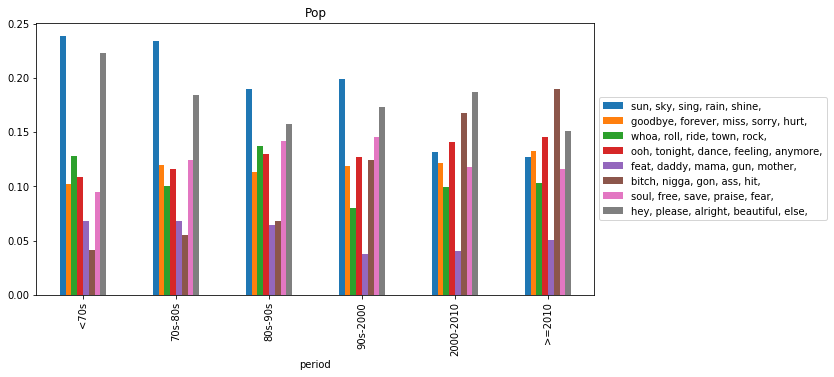

In [36]:
lyrics_lda.plot_aggregated_topics(topic_distros=topic_distros_genre_period, aggregate_period=True, 
                                  include_subcategories=["Pop"], fig_size=(10, 5))

#### **7.3.3 Rock**

Similarly to Pop music, also Rock artists seem to use less metaphors linked to nature and similar in their narrations of emotions and love, as it can be seen from the decrease in the level of topic n.1 over time (blue bar). Moreover, the dominance of topic n.3 (green bar) confirms what already explained above in section 7.1. 

Topics n.8 (woman, beautiful, ...) and n.7 (freedom, glory, ...) are also important over the years, with the latter increasing in the last decades. Finally, topic n.5 (parents/children relations) seems to have become less popular than it was in the 60s, 70s and 80s.

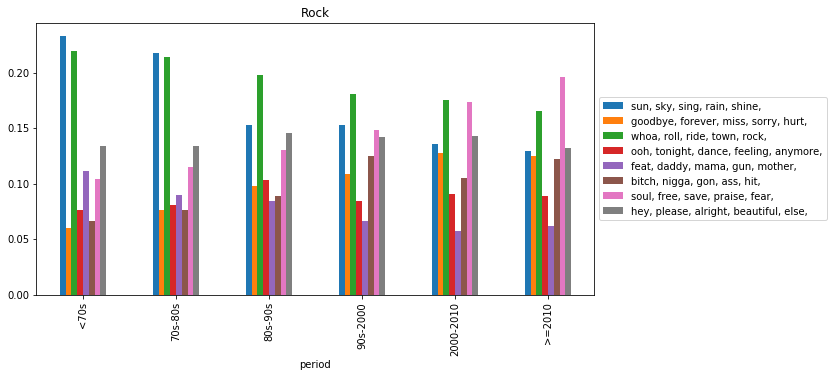

In [37]:
lyrics_lda.plot_aggregated_topics(topic_distros=topic_distros_genre_period, aggregate_period=True, 
                                  include_subcategories=["Rock"], fig_size=(10, 5))

#### **7.3.4 Country**

Concluding, in the last decades the Country genre is seeing an increase in the treatment of themes that were usually more common to Rock 'n Roll (topic n.3), while topic n.1 is seeing a decrease in popularity, similarly to what said above for Rock.

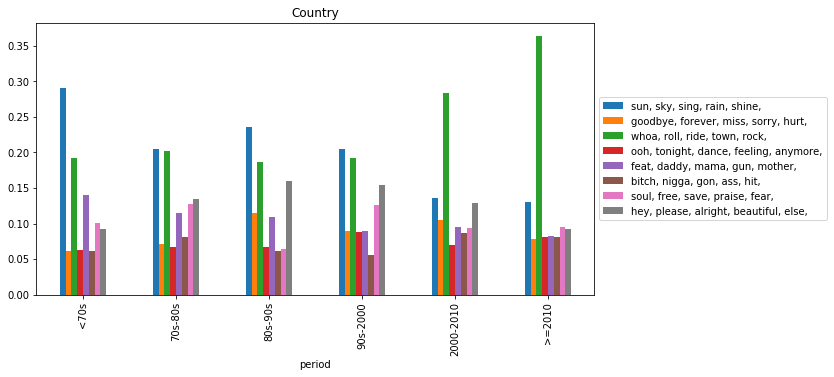

In [38]:
lyrics_lda.plot_aggregated_topics(topic_distros=topic_distros_genre_period, aggregate_period=True, 
                                  include_subcategories=["Country"], fig_size=(10, 5))

As a final remark, I would like to note that I also tried to replicate the same aggregate analysis with the Author Topic Model that we saw in class. Results were overall very close to what I outlined above, but I chose not to use it because some of them showed some inconsistencies across different runs of the model. I decided anyway to include the class I used below.

### LyricsAuthorLda CLASS

In [3]:
class LyricsAuthorLda(LyricsLda):
    
    
    def __init__(self, lyrics_df, preprocessed_corpus, authors=["genre", "period"]):
        
        super().__init__(lyrics_df=lyrics_df, preprocessed_corpus=preprocessed_corpus)
        
        self.author2doc = None
        self.author_topic_distros = None
        self.authors = authors
    
    
    def create_author2doc(self, lyrics_df=None):
        
        if lyrics_df is None:
            lyrics_df = self.lyrics_df
        
        lyrics_df = self.period_column()
        
        self.author2doc = defaultdict(list)
        for author in self.authors:
            for idx, sub_author in enumerate(lyrics_df.loc[:, author]):
                self.author2doc[sub_author].append(idx)
        return
    
    
    def choose_num_topics(self, shuffled_corpus, model_corpus, dictionary, topics_range=(1, 20), dev_size=10000, eval_size=5000, alpha=0.5):

        coherence_values = []
        author_model_list = []
        
        print("Creating dev_author2doc ...", flush=True)
        if self.lyrics_df_shuffled is None:
            dev_author2doc = {author: [idx for idx in idxs if idx < dev_size] for author, idxs in self.author2doc.items()}
            dev_author2doc = {author: idxs for author, idxs in self.author2doc.items() if len(idxs) != 0}
        else:
            lyrics_df_shuffled = self.period_column(lyrics_df=self.lyrics_df_shuffled)
            dev_author2doc = defaultdict(list)
            for author in self.authors:
                for idx, sub_author in enumerate(self.lyrics_df_shuffled.loc[:, author][:dev_size]):
                    dev_author2doc[sub_author].append(idx)

        print("Choosing topics ...", flush=True)
        for num_topics in tqdm(list(range(topics_range[0], topics_range[1]))):
            
            author_model = AuthorTopicModel(corpus=list(model_corpus[:dev_size]), 
                                    author2doc=dev_author2doc, 
                                    id2word=dictionary, 
                                    num_topics=num_topics,
                                    alpha=alpha
                                    )
            author_model_list.append(author_model)
            
            coherencemodel_umass = CoherenceModel(model=author_model, 
                                                  texts=shuffled_corpus[dev_size:dev_size+eval_size], 
                                                  dictionary=dictionary, 
                                                  coherence='u_mass')

            coherencemodel_cv = CoherenceModel(model=author_model, 
                                               texts=shuffled_corpus[dev_size:dev_size+eval_size], 
                                               dictionary=dictionary, 
                                               coherence='c_v')

            umass_score = coherencemodel_umass.get_coherence()
            cv_score = coherencemodel_cv.get_coherence()

            coherence_values.append((num_topics, umass_score, cv_score))

        self.coherence_values = coherence_values

        for coherence_value in coherence_values:
            print(coherence_value)

        return coherence_values
    
    
    def fit_transform(self, num_topics, model_corpus=None, dictionary=None, num_passes=10, num_updates=200, alpha=0.5):
        
        self.num_topics = num_topics
        
        # [1:] -> only need model corpus and dictionary
        if model_corpus is None:
            model_corpus, model_corpus_dict = self.create_lda_corpus(randomize=False)[1:]
            if dictionary is None:
                dictionary = model_corpus_dict
        
        # find chunksize to make about 200 updates
        num_passes = num_passes
        chunk_size = len(model_corpus) * num_passes/num_updates

        # fit
        with temporary_file("serialized") as s_path:
            author_model = AuthorTopicModel(
                                    model_corpus,
                                    author2doc=self.author2doc,
                                    id2word=dictionary,
                                    num_topics=num_topics,
                                    passes=num_passes,
                                    chunksize=chunk_size,
                                    alpha=alpha,
                                    serialized=True,
                                    serialization_path=s_path,
                                    )    
            author_model.update(model_corpus, self.author2doc)

        self.model = author_model
        
        return 

    
    def aggregate_topics(self):
        
        self.author_topic_distros = {author: [elem[1] for elem in self.model.get_author_topics(author)] 
                                     for author in self.model.id2author.values()
                                    }
        
        return self.author_topic_distros
    
    
    def plot_aggregated_topics(self, author_topic_distros=None, include_genres=None, fig_size=(10, 5)):
        
        if author_topic_distros is None:
            author_topic_distros = self.author_topic_distros
        
        if include_genres is None:
            include_genres = self.lyrics_df.genre.unique()
        num_genres = len(include_genres)
           
        genre_period_df = pd.DataFrame.from_dict(author_topic_distros)
        
        fig, ax = plt.subplots(nrows=num_genres, ncols=1, figsize=fig_size)
        if num_genres == 1:
            genre = include_genres[0]
            columns = f"{genre}_<70s {genre}_70s-80s {genre}_80s-90s {genre}_90s-2000 {genre}_2000-2010 {genre}_>2010".split()
            genre_period_df.loc[:, columns].T.plot.bar(ax=ax)
        else:
            print("Plotting for each genre ...", flush=True)
            for idx, genre in tqdm(enumerate(include_genres)):
                columns = f"{genre}_<70s {genre}_70s-80s {genre}_80s-90s {genre}_90s-2000 {genre}_2000-2010 {genre}_>2010".split()
                genre_period_df.loc[:, columns].T.plot.bar(ax=ax[idx])
                plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
        
        plt.show()
        
        return

## <center>**8. Doc2Vec**</center> 

In [ ]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import FAST_VERSION
from gensim.models.doc2vec import TaggedDocument
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Lyrics2Vec CLASS

In [15]:
class Lyrics2Vec():
    
    def __init__(self, lyrics_df):

        self.lyrics_df = lyrics_df
        self.doc2vec_corpus = None
        self.model = None
            
    
    def create_doc2vec_corpus(self, tag, lyrics_df=None):
        
        if lyrics_df is None:
            lyrics_df = self.lyrics_df
        
        print("Creating doc2vec tagged corpus ...", flush=True)
        tagged_corpus = []
        for row in tqdm(lyrics_df.iterrows()):
            if tag == 'genre':
                label = row[1].genre
            elif tag == 'index':
                label = row[0]
            else:
                raise AttributeError(f'Only "genre" or "index" ar valid tags. {tag} was given')
            text = row[1].lyrics
            tagged_corpus.append(TaggedDocument(text, tags=[label]))
        
        self.tagged_corpus = tagged_corpus
        return tagged_corpus
    
    
    def fit(self, tagged_corpus=None, vector_size=300, window=10, min_count=100, epochs=5000, dm=1, dbow_words=1):
        
        if tagged_corpus is None:
            tagged_corpus = self.doc2vec_corpus
        
        d2v_model = Doc2Vec(vector_size=vector_size, window=window, hs=0,
                            sample=0.000001, negative=5, min_count=min_count,
                            workers=-1, epochs=epochs, dm=dm, dbow_words=dbow_words
                           )
        d2v_model.build_vocab(tagged_corpus)
        d2v_model.train(tagged_corpus, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)
        
        self.model = d2v_model
        
        return
    
    
    @staticmethod
    def nearest_neighbors(query_vector, vectors, n=10):
        # compute cosine similarities
        ranks = np.dot(query_vector, vectors.T) / np.sqrt(np.sum(vectors
        **2, 1))
        # sort by similarity, reverse order, and get the top N
        neighbors = [idx for idx in ranks.argsort()[::-1]][:n]
        return neighbors
    
    
    def most_similar_to_genre(self, genres=None):
    
        if genres is None:
            genres = self.model.docvecs.doctags.keys()
    
        doc_words_most_similar = {}
        for tag in genres:
            doc_words_most_similar[tag] = self.nearest_neighbors(self.model.docvecs[tag], self.model.wv.vectors, n=10)
            tag_index = doc_words_most_similar[tag]
            tag_words = []
            index_to_word_mapping = {self.model.wv.vocab[word].index: word for word in self.model.wv.vocab.keys()}
            for index in tag_index:
                tag_words.append(index_to_word_mapping[index])
            doc_words_most_similar[tag] = tag_words

        return doc_words_most_similar
        
        
    def reduce_dimensionality(self, lyrics_vecs, method='tsne', n_components=3, pre_reduction_components=50):
        
        if method == 'tsne':
            
            # pre-reduce dimensionality to around 50 as advised by TSNE docs
            if not pre_reduction_components is None:
                print("Pre-reducing lyrics embeddings with PCA ...", flush=True)
                pca = PCA(n_components=pre_reduction_components)
                lyrics_vecs = pca.fit_transform(lyrics_vecs)
            
            print("Reducing lyrics embeddings with T-SNE ...", flush=True)
            tsne = TSNE(n_components=n_components)
            lyrics_vecs_reduced = tsne.fit_transform(lyrics_vecs)
                
        return lyrics_vecs_reduced
    
    
    def visualize_embeddings(self, lyrics_vecs_reduced, genres, title=None, dimensions=3, view_init=(0, 0)):
        
        if title is None:
            title = ', '.join(genres)
        
        genres_idxs = self.lyrics_df.loc[self.lyrics_df.genre.isin(genres), :].index
        genres_labels = self.lyrics_df.loc[self.lyrics_df.genre.isin(genres), :].genre.to_numpy()
        genres_vectors = lyrics_vecs_reduced[genres_idxs]
        
        # from utils.ipynb
        plot_vectors(genres_vectors, title=title, labels=genres_labels, dimensions=dimensions, view_init=view_init)

### **7.1 Genre2Vec**

Doc2Vec model where the TaggedDocument object has been constructed by assigning a genre to each document.

In [ ]:
# put preprocessed corpus into dataframe
lyrics_df_doc2vec = lyrics_cleaned.copy()
lyrics_df_doc2vec.loc[:, "lyrics"] = trimmed_corpus

In [25]:
lyrics_df_doc2vec.loc[9748:9758, :]

,artist,song,album,release_date,genre,lyrics,year
9748,Eagles,Do Something,Long Road Out Of Eden,NaN,Rock,"[walk, field, street, town, try, make, sense, ...",1985
9749,Eagles,King of Hollywood,The Long Run,1979-09-24,Rock,"[well, sit, there, leatherette, look, picture,...",1979
9750,Eagles,Midnight Flyer,On the Border,NaN,Rock,"[midnight, flyer, engineer, let, whistle, moan...",1982
9751,Eagles,Hollywood Waltz,One of These Nights,1975-06-10,Rock,"[acacia, bloom, southern, will, see, more, day...",1975
9752,Eagles,No More Cloudy Days,Long Road Out Of Eden,NaN,Rock,"[sit, foggy, window, staring, pour, rain, fall...",1979
9753,Eagles,It's Your World Now,Long Road Out Of Eden,NaN,Rock,"[perfect, day, sun, sink, low, evening, fall, ...",1980
9754,Eagles,My Man,On the Border,1974-03-24,Rock,"[tell, how, feel, like, roll, fast, spin, whee...",1974
9755,Eagles,Long Road Out Of Eden,Long Road Out Of Eden,NaN,Rock,"[moon, shine, palm, shadow, move, sand, whispe...",1973
9756,Eagles,Fast Company,Long Road Out Of Eden,2007-10-30,Rock,"[now, where, go, now, rush, listen, here, just...",2007
9757,Eagles,Somebody,Long Road Out Of Eden,NaN,Rock,"[feel, bad, bad, enough, know, come, play, rou...",1982


The aim of this part was to find the most similar words to each embedded tag (genre). Unfortunately, the result seems to be neither very informative nor reflective of what I observed so far with the other analysis.

In [21]:
genre2vec = Lyrics2Vec(lyrics_df=lyrics_df_doc2vec)

In [10]:
tagged_docs = genre2vec.create_doc2vec_corpus(tag='genre')

Creating doc2vec tagged corpus ...


43844it [00:08, 5384.32it/s]


In [11]:
genre2vec.fit(tagged_corpus=tagged_docs, vector_size=300)

In [23]:
genre_to_most_similar = genre2vec.most_similar_to_genre()

In [24]:
genre_to_most_similar

{'Hip-Hop': ['ditch',
  'cradle',
  'lady',
  'leg',
  'keep',
  'childhood',
  'imma',
  'fine',
  'tank',
  'spider'],
 'Rock': ['should',
  'sweet',
  'trial',
  'witch',
  'roach',
  'transform',
  'relationship',
  'surely',
  'audience',
  'splash'],
 'Pop': ['woo',
  'connection',
  'judge',
  'dresser',
  'lip',
  'thread',
  'forbid',
  'elevate',
  'sanctuary',
  'island'],
 'Folk': ['lake',
  'rum',
  'declare',
  'excuse',
  'cloudy',
  'pic',
  'thirsty',
  'maiden',
  'park',
  'method'],
 'Electronic': ['artist',
  'stink',
  'lost',
  'cage',
  'mercy',
  'show',
  'spoon',
  'shady',
  'break',
  'sooner'],
 'Reggae': ['ayy',
  'pressure',
  'rate',
  'explode',
  'gutter',
  'joke',
  'lie',
  'wine',
  'real',
  'package'],
 'Other': ['cast',
  'nation',
  'defense',
  'fiend',
  'existence',
  'everyday',
  'creator',
  'salvation',
  'makeup',
  'hot'],
 'Metal': ['pure',
  'business',
  'careless',
  'shorty',
  'ignorance',
  'gucci',
  'log',
  'pink',
  'bowl',

### **7.1 Song2Vec**

In this part instead I created a TaggedDocument by matching every document with its index, so that the model would train a vector embedding for each song. Then I used T-SNE to reduce the 300-dimensional vectors to 3 dimensions to visualize them and show a clustering. Unfortunately, also in this case the final result was not convincing at all: by plotting each pair of genres none of them seemed to be someway separable from any view angle or height (see the `view_init` parameter in the `self.visualize_embeddings()` method).

Below only an example of plot is shown, i.e. the one for 'Country' and 'Hip-Hop'.

In [26]:
song2vec = Lyrics2Vec(lyrics_df=lyrics_df_doc2vec)

In [27]:
tagged_songs = song2vec.create_doc2vec_corpus(tag='index')

Creating doc2vec tagged corpus ...


43844it [00:07, 5848.18it/s]


In [28]:
song2vec.fit(tagged_corpus=tagged_songs)

In [29]:
lower_dim_vectors = song2vec.reduce_dimensionality(lyrics_vecs=song2vec.model.docvecs.vectors_docs, method='tsne', n_components=3)

Pre-reducing lyrics embeddings with PCA ...
Reducing lyrics embeddings with T-SNE ...


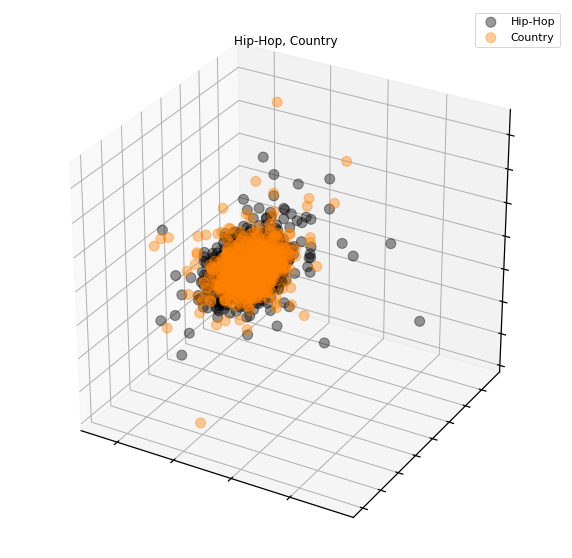

In [126]:
song2vec.visualize_embeddings(lyrics_vecs_reduced=lower_dim_vectors, 
                              genres=["Country", "Hip-Hop"], view_init=(30, 120))

## <center>**9. Clustering**</center> 

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score